<a href="https://colab.research.google.com/github/MorenoSara/Few-Shot_Text_Classification/blob/main/Few_shot_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 79 kB 4.3 MB/s 
     |████████████████████████████████| 4.2 MB 28.0 MB/s 
     |████████████████████████████████| 1.2 MB 47.9 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 596 kB 16.8 MB/s 
     |████████████████████████████████| 6.6 MB 11.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=e171add32ff63ae556970bb4583280c4bfb9ec1a677570c2783decfb9a6b4d98
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
from sentence_transformers.util import cos_sim
import numpy as np
import scipy
import random
from torch.utils.data.dataset import Dataset
from transformers import AutoTokenizer, AutoModel
from torch import nn, Tensor, sum, exp, mm, bmm
from numpy.random import choice
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns

random_seed = 42

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load data

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/WebOfScience datasets/train.xlsx', index_col=0) # 32889 samples
train_dataset.head(10)

,Y1,Y2,Y,Domain,area,keywords,Abstract
0,5,43,115,Medical,Parkinson's Disease,deep brain stimulation; basal ganglia; parkin...,The subthalamic nucleus (STN) and globus palli...
1,0,1,1,CS,Machine learning,Supervised classification; Label ranking prob...,Preference learning is the branch of machine l...
2,0,7,7,CS,Parallel computing,Track fitting; Track reconstruction; Multiple...,Modern semiconductor detectors allow for charg...
3,6,6,131,biochemistry,Polymerase chain reaction,bacterial community; calves; probiotics; rume...,The objective of this study was to assess the ...
4,6,6,131,biochemistry,Polymerase chain reaction,Bladder cancer; glycoprotein nonmetastatic me...,Glycoprotein nonmetastatic melanoma protein B ...
5,3,1,53,MAE,Hydraulics,Groundwater hydraulics; Aquitard; Bangladesh;...,Identifying flow processes in multi-aquifer fl...
6,6,2,127,biochemistry,Human Metabolism,BORON; MANGANESE; MEMBRANES; CELL WALLS; NADH...,Boron has been recognized since 1923 as an ess...
7,2,7,40,Psychology,Depression,putamen; basal ganglia; magnetic resonance im...,Putamen volume is seen to alter in neurologica...
8,0,4,4,CS,Operating systems,Wireless sensor networks; localized interacti...,Wireless sensor networks (WSNs) are characteri...
9,2,4,37,Psychology,Prosocial behavior,Eye contact effects; Therapeutic implications...,Introduction. The perception of a direct gaze ...


In [ ]:
REMAP_LEV1 = {'CS': 'Computer Science', 
              'Civil': 'Civil Engineering', 
              'ECE': 'Electrical Engineering', 
              'Psychology': 'Psychology', 
              'MAE': 'Mechanical Engineering', 
              'Medical': 'Medical Science', 
              'biochemistry': 'Biochemistry'}

In [ ]:
def get_mapped_labels(data, mapping_dict):
  labels = [l.strip() for l in data]
  return list(map(lambda l: mapping_dict[l], labels))

In [ ]:
labels = get_mapped_labels(set(train_dataset['Domain']), REMAP_LEV1)
abstracts = train_dataset['Abstract']

In [ ]:
labels

['Electrical Engineering',
 'Mechanical Engineering',
 'Civil Engineering',
 'Biochemistry',
 'Computer Science',
 'Psychology',
 'Medical Science']

### Compute entropy

In [ ]:
st_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
labels_embeddings = st_model.encode(labels)

In [ ]:
# compute the document embeddings once and save then in a file
# doc_embeddings = st_model.encode(abstracts, batch_size = 256, show_progress_bar=True) # directly encode the entire documents 
#with open('doc_embeddings.txt','wb') as f:
    #for line in np.matrix(doc_embeddings):
        #np.savetxt(f, line)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/doc_embeddings.txt', sep = ' ', header=None) 
# retrieve corresponding document using train_dataset.iloc[i]

In [ ]:
def floored_cosine_tensors(X, Y):
  sim = cos_sim(X, Y)
  return np.maximum(0, sim)

In [ ]:
def get_entropies(text_embeddings, labels_embeddings):
  probs = floored_cosine_tensors(text_embeddings, labels_embeddings)
  normalized_probs = probs/np.linalg.norm(probs, axis = 1).reshape(-1,1)
  normalized_entropy = scipy.stats.entropy(normalized_probs, axis = 1)/np.log(labels_embeddings.shape[0])
  print(normalized_entropy.shape)
  return normalized_entropy

In [ ]:
df = df.astype(np.float32)
doc_embeddings = np.asarray(df)
entropies = get_entropies(doc_embeddings, labels_embeddings)

(32889,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train_dataset['Domain'] = get_mapped_labels(train_dataset['Domain'], REMAP_LEV1)
train_dataset['Entropy'] = entropies
train_df = train_dataset.copy(deep = True)
train_df.dropna(inplace=True)
train_df

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,5,43,115,Medical Science,Parkinson's Disease,deep brain stimulation; basal ganglia; parkin...,The subthalamic nucleus (STN) and globus palli...,0.577499
1,0,1,1,Computer Science,Machine learning,Supervised classification; Label ranking prob...,Preference learning is the branch of machine l...,0.784086
2,0,7,7,Computer Science,Parallel computing,Track fitting; Track reconstruction; Multiple...,Modern semiconductor detectors allow for charg...,0.543961
3,6,6,131,Biochemistry,Polymerase chain reaction,bacterial community; calves; probiotics; rume...,The objective of this study was to assess the ...,0.358490
4,6,6,131,Biochemistry,Polymerase chain reaction,Bladder cancer; glycoprotein nonmetastatic me...,Glycoprotein nonmetastatic melanoma protein B ...,0.337900
...,...,...,...,...,...,...,...,...
32884,5,26,98,Medical Science,HIV/AIDS,Biomarkers; Cytokine; HIV; Gingival crevicula...,Objective: This study evaluates the potential ...,0.349118
32885,3,3,55,Mechanical Engineering,Machine design,Red Catuai; Poisson's ratio; density; elastic...,The finite element method has been employed in...,0.766171
32886,2,18,51,Psychology,Problem-solving,health care issues; health care utilization; ...,The University Hospital of Zurich offers a tex...,0.699593
32887,5,41,113,Medical Science,Overactive Bladder,attentional and interoceptive networks; brain...,BACKGROUND: Treatment of urgency urinary incon...,0.828843


Create a dataframe for each label

In [ ]:
# for centoids selecion technique
dfs = {}
for label in labels:
  dfs[f"{label.replace(' ', '_')}"] = train_dataset[train_dataset['Domain'] == label]

In [ ]:
# for all other techniques
dfs = {}
for label in labels:
  dfs[f"{label.replace(' ', '_')}"] = train_df[train_df['Domain'] == label]

In [ ]:
class document_class(Dataset):
  def __init__(self, documents, labels):
    self.train_df = []
    for id, doc in enumerate(documents):
      curr_doc = [labels[id]]
      curr_doc.append(doc) 
      self.train_df.append(curr_doc)
  
  def __getitem__(self, index):
    return self.train_df[index] 

  def __len__(self):
    return len(self.train_df)

In [ ]:
def my_collate_fn(batch):
  documents = []
  labels = []
  for doc in batch:
    documents.append(doc[1])
    labels.append(list(doc[0]))
  return (documents, torch.Tensor(labels))

In [ ]:
def save_model(model, model_path):
    """Save model."""
    torch.save(model.state_dict(), model_path)

def load_model(model, model_path, use_cuda=True):
    """Load model."""
    map_location = 'cpu'
    if use_cuda and torch.cuda.is_available():
        map_location = 'cuda:0'
    model.load_state_dict(torch.load(model_path, map_location))
    return model

# Models

## Freeze sentence transformer and train classifier on top - ST-C

In [ ]:
class Classifier(nn.Module):
  def __init__(self, in_dim, out_dim, device, dropout = 0.3):
    super().__init__()
    self.classification = nn.Linear(in_features=in_dim, out_features=out_dim)
    torch.nn.init.eye_(self.classification.weight)
    torch.nn.init.zeros_(self.classification.bias)
    self.device = device
    self.dropout = nn.Dropout(dropout)
    self.to(device)

  def forward(self, documents_embeddings):
    docs = self.dropout(documents_embeddings)
    scores = self.classification(docs) # assign a score to each class for every document
    return scores

## Finetune the sentence transformer - ST-raw

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, device, model_name: str = 'sentence-transformers/all-mpnet-base-v2') -> None:
        super(TextEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    # def forward(self, text: Union[str, List[str]]) -> Tensor:
    def forward(self, text) -> torch.Tensor:
        inp = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        inp = inp.to(device)
        out = self.model(**inp)[0]  # First element of model_output contains all token embeddings.
        out = self.mean_pooling(out, inp['attention_mask'])
        if isinstance(text, str):  # If input is just 1 string -> return 1D embeddings.
            out = out.squeeze(0)
        return nn.functional.normalize(out, p=2, dim=-1)

    def mean_pooling(self, token_embeddings, attention_mask):
        input_mask_expanded = \
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
class complete_model_finetuning(nn.Module):
  def __init__(self, sentence_transformer_model, st_embedding_dimension, num_classes, device):
    super().__init__()
    self.st = TextEncoder(device, sentence_transformer_model)
    self.device = device
    self.to(device)

  def forward(self, documents):
    docs = self.st(documents) # assign a score to each class for every document
    return docs

In [ ]:
class CompleteModelFinetuningWithClassifier(nn.Module): # necessary for the supervised training
  def __init__(self, sentence_transformer_model, st_embedding_dimension, out_dim, device):
    super().__init__()
    self.st = TextEncoder(device, sentence_transformer_model)
    self.device = device
    self.classification = nn.Linear(in_features=st_embedding_dimension, out_features=out_dim)
    torch.nn.init.eye_(self.classification.weight)
    torch.nn.init.zeros_(self.classification.bias)
    self.dropout = nn.Dropout(0.3)
    self.to(device)

  def forward(self, documents):
    docs = self.st(documents) # assign a score to each class for every document
    scores = self.classification(self.dropout(docs)) # assign a score to each class for every document
    return scores

# Few-shot selection techniques
Works also for one shot classification

In [ ]:
N_shots = 1# number of examples for each class

### Random

In [ ]:
def random_selection(dfs, N_shots):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      N_shots_data.append(dfs[k].iloc[choice(len(dfs[k]), N_shots, replace = False)]) # sort the values according to their entropy 
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

In [ ]:
dataframes = random_selection(dfs, 5)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,6,7,132,Biochemistry,Northern blotting,PLD2 mRNA; hypoxia-ischemia; necrosis; spopto...,Phospholipase D (PLD) and phosphatidylcholine ...,0.371895
1,6,8,133,Biochemistry,Southern blotting,Banana streak virus; Badnavirus; IC-PCR; diag...,Banana streak virus (BSV) is a significant con...,0.781571
2,6,6,131,Biochemistry,Polymerase chain reaction,HLA-B*52,HLA-B*52:01:27 differs from HLA-B*52:01:01 by ...,0.322504
3,6,4,129,Biochemistry,Genetics,Affective temperaments; Mood disorders; Valid...,Background: The assessment of affective temper...,0.629275
4,6,3,128,Biochemistry,Immunology,Immunology; Cancer; Immune surveillance; Esca...,"Despite having been much debated, it is now we...",0.331137
5,4,6,67,Civil Engineering,Stealth Technology,Thin-film interference; optical coatings; col...,Optical absorbers find uses in a wide array of...,0.311781
6,4,1,62,Civil Engineering,Geotextile,asphalt pavement widening; reflective crack p...,To investigate the reflective crack-propagatio...,0.436915
7,4,3,64,Civil Engineering,Rainwater Harvesting,green land; infiltration facilities; rainwate...,Rainwater is an underutilized water resource t...,0.284856
8,4,10,71,Civil Engineering,Smart Material,hysteresis; inverse compensation; piezoelectr...,Micro/nano positioning technologies have been ...,0.542741
9,4,2,63,Civil Engineering,Remote Sensing,Jhum; Domestication; Agroforestry,People-forest interactions in protected area h...,0.697091


### Entropy

In [ ]:
def entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 
      # select the document with the highest entropy
        first = ordered.iloc[0] # the first element has the highest entropy
        N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
        N_shots_embeddings.append(ordered_embeddings[0])
        ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
        ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = entropy(dfs, 3)
dataframes

### Distance

In [ ]:
def distance(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance'] = np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance'] = np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
        N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = distance(dfs, N_shots)
dataframes

### Entropy * Distance from centroid

In [ ]:
def distance_times_entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2] 
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance*entropy']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance*entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
        N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = distance_times_entropy(dfs, 3)
dataframes

### Entropy + Distance from centroid

In [ ]:
def distance_plus_entropy(dfs, N_shots, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2]  
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy + Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['distance+entropy']) # retrieve the id of the documnet with the highest distance*entropy
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy + Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance+entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
        N_shots_data.append(top) # save it
        
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = distance_plus_entropy(dfs, 1)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,3,1,53,Mechanical Engineering,Hydraulics,fine roots; native embolism; refilling; starc...,Restoration of an adequate water supply in spr...,0.799582
1,2,0,33,Psychology,Prejudice,highly skilled labor migration; Sweden; Japan...,"As labor markets become increasingly global, c...",0.799835
2,5,9,81,Medical Science,Skin Care,Early mobility in intensive care unit; Mobili...,BACKGROUND: Pressure ulcer formation continues...,0.799966
3,4,9,70,Civil Engineering,Construction Management,Construction management; Health hazards; Cons...,A theory-based intervention strategy to improv...,0.799878
4,1,13,30,Electrical Engineering,State space representation,Fuzzy transform; Concentrated solar collector...,This paper deals with the control of concentra...,0.799784
5,0,7,7,Computer Science,Parallel computing,Fast fuzzy c-means algorithm; Image segmentat...,The research on underwater image segmentation ...,0.799874
6,6,3,128,Biochemistry,Immunology,time-delay; cancer immunotherapy; gene-regula...,"In this paper, we analyse the local stability ...",0.798928


### $\alpha Entropy+ (1-\alpha) Distance$

In [ ]:
def tradeoff(dfs, N_shots, alpha = 0.7, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2] 
      #ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # alpha * Entropy + (1 - alpha) Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['aE+(1-a)D']) # retrieve the id of the documnet with the highest alpha * Entropy + (1-alpha)distance
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # alpha * Entropy + (1-alpha)Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['aE+(1-a)D'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
        N_shots_data.append(top) # save it
        
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

In [ ]:
dataframes = tradeoff(dfs, 3)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy,aE+(1-a)D
0,0,7,7,Computer Science,Parallel computing,Fast fuzzy c-means algorithm; Image segmentat...,The research on underwater image segmentation ...,0.799874,NaN
1,0,0,0,Computer Science,Computer vision,cell division rate; computer vision; elementa...,To understand how root growth responds to temp...,0.799670,0.921985
2,0,15,15,Computer Science,Data structures,Data structures; Suffix array; LCP array; Lin...,We show how the longest common prefix (LCP) ar...,0.799473,0.892961
3,4,9,70,Civil Engineering,Construction Management,Construction management; Health hazards; Cons...,A theory-based intervention strategy to improv...,0.799878,NaN
4,4,3,64,Civil Engineering,Rainwater Harvesting,Rainwater harvesting; Irrigation; Langevin eq...,A generic rainwater harvesting system includin...,0.799385,0.904323
5,4,9,70,Civil Engineering,Construction Management,Materiality; matter; material agency; socioma...,The increased interest for materiality as an a...,0.798634,0.858315
6,3,1,53,Mechanical Engineering,Hydraulics,fine roots; native embolism; refilling; starc...,Restoration of an adequate water supply in spr...,0.799582,NaN
7,3,0,52,Mechanical Engineering,computer-aided design,computer-aided design tools; design automatio...,The topic of this article is the development o...,0.799300,0.925771
8,3,8,60,Mechanical Engineering,Strength of materials,Defects; Fracture; Stress concentrations; Com...,This work is about the hypothesis of structura...,0.798169,0.892573
9,6,3,128,Biochemistry,Immunology,time-delay; cancer immunotherapy; gene-regula...,"In this paper, we analyse the local stability ...",0.798928,NaN


### Mixed

In [ ]:
def mixed_entropy_random(dfs, N_shots, upper_threshold = 0.8, lower_threshold = 0.5):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= upper_threshold]
      ordered = ordered[ordered['Entropy'] >= lower_threshold]
      if len(ordered) > 0: # if the dataframe has at least an entry
        N_shots_data.append(ordered.iloc[choice(len(ordered), N_shots, replace = False)]) # sort the values according to their entropy 
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

In [ ]:
dataframes = mixed_entropy_random(dfs, 1)
dataframes

### Medoids

In [ ]:
def medoids(doc_embeddings, N_shots):
  kmeans = KMeans(n_clusters = N_shots * len(labels))
  kmeans.fit(doc_embeddings)
  centroids = np.array(kmeans.cluster_centers_) # retrieve centroids
  closest, _ = vq(centroids, doc_embeddings) # selects the indices of the centroids' nearest documents -> medoids

  dataframes = train_dataset.iloc[closest]
  return dataframes.reset_index(drop=True)

In [ ]:
dataframes = medoids(doc_embeddings, 2)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract
27518,6,2,127,biochemistry,Human Metabolism,Aging-related diseases; Antioxidant activity;...,Background: Numerous diseases have been relate...
1587,2,4,37,Psychology,Prosocial behavior,Video games; Computers; Addictive behaviors; ...,The games that adolescents and young people us...
2481,3,2,54,MAE,Manufacturing engineering,Manufacturing Technology Management; Process ...,This paper presents a methodology to generate ...
28309,5,29,101,Medical,Irritable Bowel Syndrome,gender; inflammatory bowel disease; irritable...,Background: Irritable bowel syndrome (IBS) and...
3605,1,6,23,ECE,Electrical network,Optimal power flow; Mixed integer programs; L...,This article proposes a multi-period optimizat...
...,...,...,...,...,...,...,...
12210,4,7,68,Civil,Green Building,energy efficiency and carbon reduction; MEGA ...,Energy efficiency and carbon reduction of new ...
26638,5,42,114,Medical,Parenting,Fast food; Fruits and vegetables; Weight; BMI...,Purpose: To investigate agreement and associat...
28747,0,12,12,CS,Symbolic computation,Multiple exp-function method; Soliton equatio...,The multiple exp-function method is a new appr...
5147,1,14,31,ECE,PID controller,ACO; CSTR; Genetic algorithms; Integral perfo...,"In this paper, an Enhanced Genetic Algorithm (..."


### Within domain medoids

In [ ]:
def medoids_within_domain(dfs, N_shots, doc_embeddings):
  N_shots_data = []
  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry
      within_domain_embeddings = doc_embeddings[dfs[k].index]
      kmeans = KMeans(n_clusters = N_shots)
      kmeans.fit(within_domain_embeddings)
      within_domain_centroids = np.array(kmeans.cluster_centers_) # retrieve centroids within the domain
      closest, _ = vq(within_domain_centroids, within_domain_embeddings) # selects the indices of the centroids' nearest documents -> medoids
      N_shots_data.append(train_dataset.loc[dfs[k].index].iloc[closest])
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

In [ ]:
dataframes = medoids_within_domain(dfs, 1, doc_embeddings)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,0,15,15,Computer Science,Data structures,Pervasive computing; Grid management; Remote ...,Rapid development of new technologies for info...,0.890176
1,4,7,68,Civil Engineering,Green Building,Sustainable infrastructure; Systematic litera...,This paper proposes a taxonomy of themes and a...,0.677140
2,3,7,59,Mechanical Engineering,Materials Engineering,Integrated Computational Materials Engineerin...,Turbine engines provide a challenging environm...,0.515260
3,5,13,85,Medical Science,Crohn's Disease,Patient reported outcome measures; questionna...,Patient reported outcome measures [PROMs] are ...,0.448699
4,2,9,42,Psychology,Seasonal affective disorder,DSM-V; disorders; background; proposals; crit...,"Throughout its history, one of the most fascin...",0.759136
5,1,15,32,Electrical Engineering,Operational amplifier,Computer simulation; Electronic simulator; Sy...,"In the last years, there is a greater interest...",0.829328
6,6,7,132,Biochemistry,Northern blotting,natural antisense transcripts; transcription ...,High-throughput sequencing has identified a la...,0.333441


### Entropy and centroids

In [ ]:
def entropy_and_cenotrids(train_df, N_shots, upper_threshold = 0.8, lower_threshold = 0.4):
  kmeans = KMeans(n_clusters = N_shots * len(labels))
  ordered = train_df[train_df['Entropy'] <= upper_threshold]
  ordered = ordered[ordered['Entropy'] >= lower_threshold]
  selected_embeddings = [doc_embeddings[i] for i in ordered.index]
  kmeans.fit(selected_embeddings)
  centroids = np.array(kmeans.cluster_centers_) # retrieve centroids
  closest, _ = vq(centroids, selected_embeddings)
  dataframes = ordered.iloc[closest]
  return dataframes.reset_index(drop=True)

### Entropy without domains

In [ ]:
def entropy_no_domain(train_df, N_shots, threshold = 0.8):
  N_shots_data = []
  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*len(labels)] 
  return ordered.reset_index(drop=True)

### Distance without domains

In [ ]:
def distance_no_domain(train_df, N_shots, threshold = 0.8):
  N_shots_data = []
  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*len(labels)*10]
  ordered_embeddings = doc_embeddings[ordered.index]
  N_shots_embeddings = [] # list successively used to compute the centroid

  for i in range(N_shots*len(labels)): 

    if i == 0: # select the document with the highest entropy
      first = ordered.iloc[0] # the first element has the highest entropy
      N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
      N_shots_embeddings.append(ordered_embeddings[0])
      ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
      ordered['distance'] = np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
      ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
      continue # go to the second point
    first_id = np.argmax(ordered['distance']) # retrieve the id of the documnet with the highest distance*entropy
    first = ordered.iloc[first_id] # get the corresponding document
    N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
    centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
    ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
    ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
    ordered['distance'] = np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
    top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
    N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

### Entropy * Distance without domains

In [ ]:
def distance_times_entropy_no_domain(train_df, N_shots, threshold = 0.8):
  N_shots_data = []

  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*len(labels)*10] 
  ordered_embeddings = doc_embeddings[ordered.index]

  N_shots_embeddings = [] # list successively used to compute the centroid

  for i in range(N_shots*len(labels)): 

    if i == 0: # select the document with the highest entropy
      first = ordered.iloc[0] # the first element has the highest entropy
      N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
      N_shots_embeddings.append(ordered_embeddings[0])
      ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
      ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy * Euclidean_distance(highest_entropy - all_other_points)
      ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
      continue # go to the second point

    first_id = np.argmax(ordered['distance*entropy']) # retrieve the id of the documnet with the highest distance*entropy
    first = ordered.iloc[first_id] # get the corresponding document
    N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
    centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
    ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
    ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
    ordered['distance*entropy'] = ordered['Entropy']*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy * Euclidean_distance(centroid - remaining_points)
    top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance*entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy*Distance
    N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

### Entropy + Distance without domains

In [ ]:
def distance_plus_entropy_no_domain(train_df, N_shots, threshold = 0.8):
  N_shots_data = []

  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*len(labels)*10] 
  ordered_embeddings = doc_embeddings[ordered.index]

  N_shots_embeddings = [] # list successively used to compute the centroid

  for i in range(N_shots*len(labels)): 

    if i == 0: # select the document with the highest entropy
      first = ordered.iloc[0] # the first element has the highest entropy
      N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
      N_shots_embeddings.append(ordered_embeddings[0])
      ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
      ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # Entropy + Euclidean_distance(highest_entropy - all_other_points)
      ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
      continue # go to the second point

    first_id = np.argmax(ordered['distance+entropy']) # retrieve the id of the documnet with the highest distance*entropy
    first = ordered.iloc[first_id] # get the corresponding document
    N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
    centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
    ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
    ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
    ordered['distance+entropy'] = ordered['Entropy']+np.linalg.norm(centroid-ordered_embeddings, axis = 1) # Entropy + Euclidean_distance(centroid - remaining_points)
    top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['distance+entropy'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
    N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

### $\alpha Entropy+ (1-\alpha) Distance$ without domains

In [ ]:
def tradeoff_no_domain(train_df, N_shots, alpha = 0.7, threshold = 0.8):
  N_shots_data = []

  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*len(labels)*10] 
  ordered_embeddings = doc_embeddings[ordered.index]

  N_shots_embeddings = [] # list successively used to compute the centroid

  for i in range(N_shots*len(labels)): 

    if i == 0: # select the document with the highest entropy
      first = ordered.iloc[0] # the first element has the highest entropy
      N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
      N_shots_embeddings.append(ordered_embeddings[0])
      ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
      ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # alpha * Entropy + (1 - alpha) Euclidean_distance(highest_entropy - all_other_points)
      ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
      continue # go to the second point

    first_id = np.argmax(ordered['aE+(1-a)D']) # retrieve the id of the documnet with the highest alpha * Entropy + (1-alpha)distance
    first = ordered.iloc[first_id] # get the corresponding document
    N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
    centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
    ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
    ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
    ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # alpha * Entropy + (1-alpha)Euclidean_distance(centroid - remaining_points)
    top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['aE+(1-a)D'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
    N_shots_data.append(top) # save it

  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

### Mixed without domains

In [ ]:
def mixed_entropy_random_no_domain(train_df, N_shots, upper_threshold = 0.8, lower_threshold = 0.5):
  N_shots_data = []

  ordered = train_df.iloc[(train_df['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
  ordered = ordered[ordered['Entropy'] <= upper_threshold]
  ordered = ordered[ordered['Entropy'] >= lower_threshold]
  if len(ordered) > 0: # if the dataframe has at least an entry
    N_shots_data.append(ordered.iloc[choice(len(ordered), N_shots*len(labels), replace = False)]) # sort the values according to their entropy 
  dataframes = pd.concat(N_shots_data).reset_index(drop=True)
  return dataframes

# Test set


In [ ]:
test_dataset = pd.read_excel('/content/drive/MyDrive/WebOfScience datasets/test.xlsx', index_col=0)
test_docs = test_dataset['Abstract']
test_labels = get_mapped_labels(test_dataset['Domain'], REMAP_LEV1)

# Few-shot supervision

In [ ]:
class NContrastiveLoss(nn.Module):
    '''
    Compute generalised Contrastive Loss, where there is 1 positive and N negative labels
    for each instance. The embedding of the instance gets pulled close to the positive
    label embedding while being pushed away from each of the N negative labels embeddings.
    https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html
    '''
    def __init__(self) -> None:
        super(NContrastiveLoss, self).__init__()

    def forward(self, anchor: Tensor, positive: Tensor, negatives: Tensor) -> torch.float:
        '''
        Pulls anchor and positive closer together and pushes anchor and negatives further
        apart.
        For each example in the batch, there is 1 anchor, 1 positive and N negatives.
        The loss formulated here optimizes the dot product.

        Parameters
        ----------
        anchor: 2D tensor
                batch of anchors embeddings
        positive: 2D tensor
                  batch of positive embedding
        negatives : 3D tensor
                    batch of N-negatives embeddings per

        Returns
        -------
        Float tensor
            Sum of N-contrastive-loss for each element of the batch.
        '''
        # Make anchor and positive tensors 3D, by expanding empty dimension 1.
        batch_size = len(anchor)
        anchor = anchor.unsqueeze(1)
        positive = positive.unsqueeze(1)
        # Compute loss.
        A = exp(bmm(anchor, positive.transpose(2, 1))).view(batch_size)
        B = sum(exp(bmm(anchor, negatives.transpose(2, 1)).squeeze(1)), dim=-1)
        return -sum(torch.log(A / (A + B)), dim=-1) / batch_size

In [ ]:
def floored_cosine_knn(x, y):
  norm_x = x/np.linalg.norm(x)
  norm_y = y/np.linalg.norm(y)
  return max(0.0, 1 - np.dot(norm_x, norm_y))

## ST-C - Train only the classifier on top

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

lab_embeddings = model.encode(labels, convert_to_tensor=True)

Save file

In [ ]:
# test_embeddings = model.encode(list(test_docs), convert_to_tensor=True, show_progress_bar = True)
# with open('/content/drive/MyDrive/test_embeddings.txt','wb') as f:
#     for line in np.matrix(test_embeddings.cpu()):
#         np.savetxt(f, line)

Read file

In [ ]:
test_embeddings = pd.read_csv('/content/drive/MyDrive/test_embeddings.txt', sep = ' ', header=None)
test_embeddings = test_embeddings.astype(np.float32)
test_embeddings = np.asarray(test_embeddings)

### Test on a single number of shots

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
  
dataframes = medoids(doc_embeddings, 27)

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
  
classifier_unsupervised = Classifier(768, 768, device)

lr = 1e-2
epochs = 3
batch_size = 256

criterion = NContrastiveLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_unsupervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

documents_emb = model.encode(dataframes['Abstract'], convert_to_tensor=True)
labels_encoding = model.encode(labels, convert_to_tensor=True)
lab2emb = dict(zip(labels, labels_encoding))

documents = tuple(zip(dataframes['Domain'], np.asarray(documents_emb.cpu())))
training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)

In [ ]:
writer = SummaryWriter()

for epoch in range(epochs):

  training_loss = 0

  classifier_unsupervised.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    encoded_labs = classifier_unsupervised(lab_embeddings)
    lab2emb = dict(zip(labels, encoded_labs)) # associate the endoding with the respective label
    docs = docs.to(device)
    negatives_list = []
    positive_list = []
    for positive in training_labels: # for each training label that is the positive for the considered anchor
      x = [v for k, v in lab2emb.items() if not k == positive] # select all the embeddings of the labels that are different from the positive one
      pos = [v for k, v in lab2emb.items() if k == positive] # select the positive label's embedding
      negatives_list.append(torch.stack(x)) # append in a list the tensor matrices of the negative labels' embeddings
      positive_list.extend(pos) # extend the list containing all the postive embeddings 
    negatives = torch.stack(negatives_list) # cread a 3D tensor matrix (batch_size, num_labels - 1, embedding_dimension)
    positives = torch.stack(positive_list) # create a 2D tensor matrix (batch_size, embedding_dimension)
    negatives = negatives.to(device)
    positives = positives.to(device)
    document_embeddings = classifier_unsupervised(docs)
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

    classifier_unsupervised.eval()
    test_document_embeddings = []

    with torch.no_grad():
      label_embeddings = classifier_unsupervised(lab_embeddings)

    test_dataloader = DataLoader(test_embeddings, batch_size=256, shuffle=False)
    for test_docs in test_dataloader:
      with torch.no_grad():
        embs = classifier_unsupervised(test_docs)
      test_document_embeddings.extend(embs)

    test_document_embeddings = torch.stack(test_document_embeddings) # create the 2D matrix with the embeddings of the test documents
    knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn) # just 1 neighbour
    knn.fit(label_embeddings.cpu(), labels)
    y_pred = knn.predict(test_document_embeddings.cpu()) # find the nearest label to each document
    F1 = f1_score(test_labels, y_pred, average='macro')
    print(f'Epoch: {epoch}, F1 macro: {F1}')

    writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

Batch: 0/1, epoch: 0/3. Training loss: 1.814.
Epoch: 0, F1 macro: 0.6782660298281431
Batch: 0/1, epoch: 1/3. Training loss: 0.873.
Epoch: 1, F1 macro: 0.6931632602329154
Batch: 0/1, epoch: 2/3. Training loss: 0.578.
Epoch: 2, F1 macro: 0.6959767792870749


### Test on a range of shots

In [ ]:
writer = SummaryWriter()

def train_and_test(model, training_epochs, training_dataloader, criterion, optimizer, test_label_embeddings, test_doc_embeddings, n_shot):
  f = open("results.txt", "a")
  f.write(f"\nN-shots: {n_shot}\n")
  for epoch in range(training_epochs):

    training_loss = 0

    model.train()

    for batch, (training_labels, docs) in enumerate(training_dataloader):
      encoded_labs = model(lab_embeddings)
      lab2emb = dict(zip(labels, encoded_labs))
      docs = docs.to(device)
      negatives_list = []
      positive_list = []
      for positive in training_labels: # for each training label that is the positive for the considered anchor
        x = [v for k, v in lab2emb.items() if not k == positive] # select all the embeddings of the labels that are different from the positive one
        pos = [v for k, v in lab2emb.items() if k == positive] # select the positive label's embedding
        negatives_list.append(torch.stack(x)) # append in a list the tensor matrices of the negative labels' embeddings
        positive_list.extend(pos) # extend the list containing all the postive embeddings 
      negatives = torch.stack(negatives_list) # cread a 3D tensor matrix (batch_size, num_labels - 1, embedding_dimension)
      positives = torch.stack(positive_list) # create a 2D tensor matrix (batch_size, embedding_dimension)
      negatives = negatives.to(device)
      positives = positives.to(device)
      document_embeddings = model(docs)
      loss = criterion(document_embeddings, positives, negatives)
      optimizer.zero_grad()
      loss.backward(retain_graph=True)
      training_loss += loss
      optimizer.step()

    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

    model.eval()
    test_document_embeddings = []

    with torch.no_grad():
      label_embeddings = model(test_label_embeddings)

    test_dataloader = DataLoader(test_doc_embeddings, batch_size=256, shuffle=False)
    for docs in tqdm(test_dataloader):
      docs = docs.to(device)
      with torch.no_grad():
        embs = model(docs)
      test_document_embeddings.extend(embs)

    test_document_embeddings = torch.stack(test_document_embeddings)
    knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
    knn.fit(label_embeddings.cpu(), labels)
    y_pred = knn.predict(test_document_embeddings.cpu())
    F1 = f1_score(test_labels, y_pred, average='macro')
    if epoch == 2:
      epoch_3 = F1
      writer.add_scalar("F1_macro/N-shots", F1, n_shot)
    print(f'N-shots: {n_shot}, F1 macro: {F1}')

    f.write(f"Epoch: {epoch+1}, F1 macro : {F1} - ")

  f.close()
  return epoch_3
writer.flush()

In [ ]:
def select_few_shots(dfs, shot_selection, N_shots, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5, doc_embeddings = doc_embeddings):
  if shot_selection == "R":
    dataframe = random_selection(dfs, N_shots)
  elif shot_selection == "E":
    dataframe = entropy(dfs, N_shots, threshold)
  elif shot_selection == "D":
    dataframe = distance(dfs, N_shots, threshold)
  elif shot_selection == "E*D":
    dataframe = distance_times_entropy(dfs, N_shots, threshold)
  elif shot_selection == "E+D":
    dataframe = distance_plus_entropy(dfs, N_shots, threshold)
  elif shot_selection == "tradeoff":
    dataframe = tradeoff(dfs, N_shots, threshold, alpha)
  elif shot_selection == "M":
    dataframe = mixed_entropy_random(dfs, N_shots)
  elif shot_selection == "C":
    dataframe = medoids(doc_embeddings, N_shots)
  elif shot_selection == "WD":
    dataframe = medoids_within_domain(dfs, N_shots, doc_embeddings)
  elif shot_selection == "EM":
    dataframe = entropy_and_cenotrids(train_df, N_shots)
  elif shot_selection == "END":
    dataframe = entropy_no_domain(train_df, N_shots)
  elif shot_selection == "DND":
    dataframe = distance_no_domain(train_df, N_shots)
  elif shot_selection == "E*D_ND":
    dataframe = distance_times_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "E+D_ND":
    dataframe = distance_plus_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "tradeoff_ND":
    dataframe = tradeoff_no_domain(train_df, N_shots, threshold, alpha)
  elif shot_selection == "MND":
    dataframe = mixed_entropy_random_no_domain(dfs, N_shots)
  return dataframe

In [ ]:
def test_few_shot(sentence_transformer, dataframes, shot_selection, shots, epochs, lr, batch_size = 256, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5, doc_embeddings = doc_embeddings):
  epoch_3 = []
  f = open("results.txt", "a")
  if shot_selection == "R":
    f.write(f"{shots[-1]} shots - Random:")
  elif shot_selection == "E":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only entropy:")
  elif shot_selection == "D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only distance:")
  elif shot_selection == "E*D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance:")
  elif shot_selection == "E+D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance:")
  elif shot_selection == "tradeoff":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff:")
  elif shot_selection == "M":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random):")
  elif shot_selection == "C":
    f.write(f"{shots[-1]} shots - Centroids:")
  elif shot_selection == "WD":
    f.write(f"{shots[-1]} shots - Within domain centroids:")
  elif shot_selection == "EM":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Entropy with Medoids:")
  elif shot_selection == "END":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only entropy NO DOMAIN:")
  elif shot_selection == "DND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only distance NO DOMAIN:") 
  elif shot_selection == "E*D_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance NO DOMAIN:")
  elif shot_selection == "E+D_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance NO DOMAIN:")
  elif shot_selection == "tradeoff_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff NO DOMAIN:")
  elif shot_selection == "MND":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random) NO DOMAIN:")
  criterion = NContrastiveLoss()
  f.close()
  for N_shots in shots:

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device == 'cuda':
      torch.cuda.set_device(gpu_no)
      torch.cuda.manual_seed(random_seed)

    data = select_few_shots(dataframes, shot_selection, N_shots, threshold, alpha, doc_embeddings) # select the shots used for training

    classifier_unsupervised = Classifier(768, 768, device)
    documents_emb = sentence_transformer.encode(data['Abstract'], convert_to_tensor=True, show_progress_bar=True) # compute the embedding of the selected documents

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_unsupervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)
    documents = tuple(zip(data['Domain'], np.asarray(documents_emb.cpu())))
    training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)
    F1_3 = train_and_test(classifier_unsupervised, epochs, training_dataloader, criterion, optimizer, lab_embeddings, test_embeddings, N_shots)
    epoch_3.append(F1_3)

  f = open("results.txt", "a")
  f.write(f"\nEpoch 3 F1 scores: {epoch_3}")
  f.write("\n\n")
  f.close()

In [ ]:
shots = np.arange(40) + 1
centroid_shots = list(np.arange(20)+1)
centroid_shots.extend([40])

In [ ]:
start_time = time.time()
test_few_shot(model, dfs, "tradeoff_ND", shots, epochs = 3, lr = 1e-2, batch_size = 32, doc_embeddings=doc_embeddings)
print("--- %s seconds ---" % (time.time() - start_time))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 499.74it/s]


N-shots: 1, F1 macro: 0.4999908731235611


100%|██████████| 37/37 [00:00<00:00, 235.14it/s]


N-shots: 1, F1 macro: 0.4741503471818148


100%|██████████| 37/37 [00:00<00:00, 244.77it/s]


N-shots: 1, F1 macro: 0.4691958767575065


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 233.15it/s]


N-shots: 2, F1 macro: 0.5815710757895547


100%|██████████| 37/37 [00:00<00:00, 96.23it/s]


N-shots: 2, F1 macro: 0.5534249227919928


100%|██████████| 37/37 [00:00<00:00, 218.48it/s]


N-shots: 2, F1 macro: 0.5540305895556958


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 327.48it/s]


N-shots: 3, F1 macro: 0.5786716366129488


100%|██████████| 37/37 [00:00<00:00, 542.46it/s]


N-shots: 3, F1 macro: 0.5532012769893192


100%|██████████| 37/37 [00:00<00:00, 539.91it/s]


N-shots: 3, F1 macro: 0.5629831259965273


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 513.51it/s]


N-shots: 4, F1 macro: 0.5981741669580306


100%|██████████| 37/37 [00:00<00:00, 490.01it/s]


N-shots: 4, F1 macro: 0.5891449547080032


100%|██████████| 37/37 [00:00<00:00, 495.75it/s]


N-shots: 4, F1 macro: 0.5963675993695322


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 482.62it/s]


N-shots: 5, F1 macro: 0.5960309998366133


100%|██████████| 37/37 [00:00<00:00, 484.07it/s]


N-shots: 5, F1 macro: 0.5895604320131772


100%|██████████| 37/37 [00:00<00:00, 532.04it/s]


N-shots: 5, F1 macro: 0.5820605265369965


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 543.88it/s]


N-shots: 6, F1 macro: 0.5914570647647116


100%|██████████| 37/37 [00:00<00:00, 469.07it/s]


N-shots: 6, F1 macro: 0.6022931332044195


100%|██████████| 37/37 [00:00<00:00, 520.91it/s]


N-shots: 6, F1 macro: 0.5992373858808312


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 487.58it/s]


N-shots: 7, F1 macro: 0.6026771024902351


100%|██████████| 37/37 [00:00<00:00, 512.84it/s]


N-shots: 7, F1 macro: 0.618114146383575


100%|██████████| 37/37 [00:00<00:00, 514.12it/s]


N-shots: 7, F1 macro: 0.6114898150250022


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 143.55it/s]


N-shots: 8, F1 macro: 0.6295439611280783


100%|██████████| 37/37 [00:00<00:00, 509.71it/s]


N-shots: 8, F1 macro: 0.6264862493412382


100%|██████████| 37/37 [00:00<00:00, 535.20it/s]


N-shots: 8, F1 macro: 0.6055788544377065


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 486.79it/s]


N-shots: 9, F1 macro: 0.6237906378063156


100%|██████████| 37/37 [00:00<00:00, 487.40it/s]


N-shots: 9, F1 macro: 0.6300518292459447


100%|██████████| 37/37 [00:00<00:00, 534.76it/s]


N-shots: 9, F1 macro: 0.6219774560395056


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 522.73it/s]


N-shots: 10, F1 macro: 0.6195770566690619


100%|██████████| 37/37 [00:00<00:00, 501.99it/s]


N-shots: 10, F1 macro: 0.587483944521506


100%|██████████| 37/37 [00:00<00:00, 537.14it/s]


N-shots: 10, F1 macro: 0.5802919784571767


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 513.98it/s]


N-shots: 11, F1 macro: 0.6344569948110158


100%|██████████| 37/37 [00:00<00:00, 504.02it/s]


N-shots: 11, F1 macro: 0.6491866323253069


100%|██████████| 37/37 [00:00<00:00, 533.40it/s]


N-shots: 11, F1 macro: 0.6414383966743127


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 508.46it/s]


N-shots: 12, F1 macro: 0.6384831205485811


100%|██████████| 37/37 [00:00<00:00, 505.71it/s]


N-shots: 12, F1 macro: 0.6375419428717964


100%|██████████| 37/37 [00:00<00:00, 503.81it/s]


N-shots: 12, F1 macro: 0.6260740684557804


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 497.00it/s]


N-shots: 13, F1 macro: 0.6228774894221906


100%|██████████| 37/37 [00:00<00:00, 549.24it/s]


N-shots: 13, F1 macro: 0.6246610392084893


100%|██████████| 37/37 [00:00<00:00, 144.04it/s]


N-shots: 13, F1 macro: 0.6349598988987559


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 514.81it/s]


N-shots: 14, F1 macro: 0.6215526751188312


100%|██████████| 37/37 [00:00<00:00, 539.68it/s]


N-shots: 14, F1 macro: 0.6351605803764008


100%|██████████| 37/37 [00:00<00:00, 516.03it/s]


N-shots: 14, F1 macro: 0.626129984363879


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 511.79it/s]


N-shots: 15, F1 macro: 0.6510929768676773


100%|██████████| 37/37 [00:00<00:00, 480.87it/s]


N-shots: 15, F1 macro: 0.6313283559098986


100%|██████████| 37/37 [00:00<00:00, 502.64it/s]


N-shots: 15, F1 macro: 0.6445202956845982


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 503.35it/s]


N-shots: 16, F1 macro: 0.6550818802787407


100%|██████████| 37/37 [00:00<00:00, 530.88it/s]


N-shots: 16, F1 macro: 0.643961508792939


100%|██████████| 37/37 [00:00<00:00, 508.83it/s]


N-shots: 16, F1 macro: 0.6428633358160424


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 509.64it/s]


N-shots: 17, F1 macro: 0.6360891673536161


100%|██████████| 37/37 [00:00<00:00, 549.61it/s]


N-shots: 17, F1 macro: 0.6317589041571248


100%|██████████| 37/37 [00:00<00:00, 486.48it/s]


N-shots: 17, F1 macro: 0.6501110811245875


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 458.92it/s]


N-shots: 18, F1 macro: 0.6651616633766191


100%|██████████| 37/37 [00:00<00:00, 138.08it/s]


N-shots: 18, F1 macro: 0.6605764620547403


100%|██████████| 37/37 [00:00<00:00, 481.37it/s]


N-shots: 18, F1 macro: 0.6445097621015098


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 518.80it/s]


N-shots: 19, F1 macro: 0.6509736466319184


100%|██████████| 37/37 [00:00<00:00, 511.45it/s]


N-shots: 19, F1 macro: 0.6121199852062267


100%|██████████| 37/37 [00:00<00:00, 536.77it/s]


N-shots: 19, F1 macro: 0.6399459656359108


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 543.26it/s]


N-shots: 20, F1 macro: 0.6779836403853416


100%|██████████| 37/37 [00:00<00:00, 520.59it/s]


N-shots: 20, F1 macro: 0.6698496879665425


100%|██████████| 37/37 [00:00<00:00, 539.41it/s]


N-shots: 20, F1 macro: 0.6635193595370356


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 443.37it/s]


N-shots: 21, F1 macro: 0.6633333018530629


100%|██████████| 37/37 [00:00<00:00, 531.98it/s]


N-shots: 21, F1 macro: 0.615886861934418


100%|██████████| 37/37 [00:00<00:00, 465.41it/s]


N-shots: 21, F1 macro: 0.6567165273887418


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 532.30it/s]


N-shots: 22, F1 macro: 0.6561154362578291


100%|██████████| 37/37 [00:00<00:00, 521.58it/s]


N-shots: 22, F1 macro: 0.6468288276793013


100%|██████████| 37/37 [00:00<00:00, 539.64it/s]


N-shots: 22, F1 macro: 0.6628692909281159


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 482.70it/s]


N-shots: 23, F1 macro: 0.6744311863822228


100%|██████████| 37/37 [00:00<00:00, 511.93it/s]


N-shots: 23, F1 macro: 0.654780609670028


100%|██████████| 37/37 [00:00<00:00, 537.02it/s]


N-shots: 23, F1 macro: 0.6473228694536771


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 529.07it/s]


N-shots: 24, F1 macro: 0.6676561420429099


100%|██████████| 37/37 [00:00<00:00, 493.58it/s]


N-shots: 24, F1 macro: 0.6797791712587441


100%|██████████| 37/37 [00:00<00:00, 541.14it/s]


N-shots: 24, F1 macro: 0.6728534879424057


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 453.41it/s]


N-shots: 25, F1 macro: 0.6761489394451


100%|██████████| 37/37 [00:00<00:00, 570.16it/s]


N-shots: 25, F1 macro: 0.6693988143564644


100%|██████████| 37/37 [00:00<00:00, 474.17it/s]


N-shots: 25, F1 macro: 0.6638800709876308


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 509.76it/s]


N-shots: 26, F1 macro: 0.6585773768396309


100%|██████████| 37/37 [00:00<00:00, 423.01it/s]


N-shots: 26, F1 macro: 0.6680965508503254


100%|██████████| 37/37 [00:00<00:00, 517.66it/s]


N-shots: 26, F1 macro: 0.6496511783378314


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 511.52it/s]


N-shots: 27, F1 macro: 0.667857665844881


100%|██████████| 37/37 [00:00<00:00, 507.04it/s]


N-shots: 27, F1 macro: 0.6741975115851074


100%|██████████| 37/37 [00:00<00:00, 513.11it/s]


N-shots: 27, F1 macro: 0.6751430768797478


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 485.45it/s]


N-shots: 28, F1 macro: 0.6581436971992495


100%|██████████| 37/37 [00:00<00:00, 523.40it/s]


N-shots: 28, F1 macro: 0.6539607947219835


100%|██████████| 37/37 [00:00<00:00, 506.82it/s]


N-shots: 28, F1 macro: 0.6502615723292797


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 505.38it/s]


N-shots: 29, F1 macro: 0.6374186961020486


100%|██████████| 37/37 [00:00<00:00, 523.74it/s]


N-shots: 29, F1 macro: 0.6729467530293698


100%|██████████| 37/37 [00:00<00:00, 534.23it/s]


N-shots: 29, F1 macro: 0.6719483481223308


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 518.98it/s]


N-shots: 30, F1 macro: 0.6745938971082415


100%|██████████| 37/37 [00:00<00:00, 522.00it/s]


N-shots: 30, F1 macro: 0.6554928457664617


100%|██████████| 37/37 [00:00<00:00, 136.17it/s]


N-shots: 30, F1 macro: 0.6639279241124855


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 500.62it/s]


N-shots: 31, F1 macro: 0.6551858622459665


100%|██████████| 37/37 [00:00<00:00, 513.28it/s]


N-shots: 31, F1 macro: 0.6673208984074449


100%|██████████| 37/37 [00:00<00:00, 536.23it/s]


N-shots: 31, F1 macro: 0.6751951745992265


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 526.28it/s]


N-shots: 32, F1 macro: 0.6667542626283159


100%|██████████| 37/37 [00:00<00:00, 503.36it/s]


N-shots: 32, F1 macro: 0.676874490021225


100%|██████████| 37/37 [00:00<00:00, 521.89it/s]


N-shots: 32, F1 macro: 0.6811286035253988


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 529.74it/s]


N-shots: 33, F1 macro: 0.6756395568264569


100%|██████████| 37/37 [00:00<00:00, 514.14it/s]


N-shots: 33, F1 macro: 0.6770273066432043


100%|██████████| 37/37 [00:00<00:00, 521.24it/s]


N-shots: 33, F1 macro: 0.6234431710094521


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 136.73it/s]


N-shots: 34, F1 macro: 0.6682553740405932


100%|██████████| 37/37 [00:00<00:00, 502.39it/s]


N-shots: 34, F1 macro: 0.6504039859885548


100%|██████████| 37/37 [00:00<00:00, 466.61it/s]


N-shots: 34, F1 macro: 0.6807261156832939


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 452.49it/s]


N-shots: 35, F1 macro: 0.6636688101825081


100%|██████████| 37/37 [00:00<00:00, 494.66it/s]


N-shots: 35, F1 macro: 0.6659844149150197


100%|██████████| 37/37 [00:00<00:00, 546.89it/s]


N-shots: 35, F1 macro: 0.681400362806154


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 512.21it/s]


N-shots: 36, F1 macro: 0.6718312429125416


100%|██████████| 37/37 [00:00<00:00, 502.30it/s]


N-shots: 36, F1 macro: 0.6637610603767576


100%|██████████| 37/37 [00:00<00:00, 513.00it/s]


N-shots: 36, F1 macro: 0.6652702735254933


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 510.59it/s]


N-shots: 37, F1 macro: 0.6627901690370752


100%|██████████| 37/37 [00:00<00:00, 504.76it/s]


N-shots: 37, F1 macro: 0.6544270532900762


100%|██████████| 37/37 [00:00<00:00, 142.48it/s]


N-shots: 37, F1 macro: 0.6453309585284204


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 508.18it/s]


N-shots: 38, F1 macro: 0.666512009858655


100%|██████████| 37/37 [00:00<00:00, 548.55it/s]


N-shots: 38, F1 macro: 0.6576750674771389


100%|██████████| 37/37 [00:00<00:00, 537.44it/s]


N-shots: 38, F1 macro: 0.6634716897535581


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 525.53it/s]


N-shots: 39, F1 macro: 0.6375616104182582


100%|██████████| 37/37 [00:00<00:00, 522.39it/s]


N-shots: 39, F1 macro: 0.649994164077701


100%|██████████| 37/37 [00:00<00:00, 467.06it/s]


N-shots: 39, F1 macro: 0.6516483277060364


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:00<00:00, 531.34it/s]


N-shots: 40, F1 macro: 0.649470898814948


100%|██████████| 37/37 [00:00<00:00, 486.40it/s]


N-shots: 40, F1 macro: 0.6740464447795775


100%|██████████| 37/37 [00:00<00:00, 538.00it/s]


N-shots: 40, F1 macro: 0.674537782142414
--- 410.7021470069885 seconds ---


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


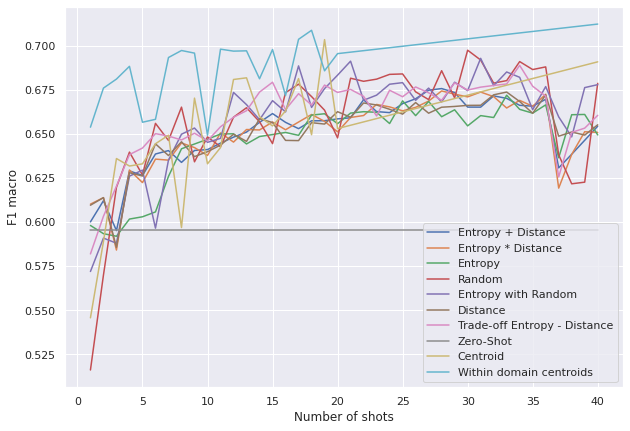

In [ ]:
EpD = [0.6000795942619116, 0.6120813379678692, 0.5951475535536553, 0.6290199598630872, 0.6264411618444908, 0.6386178847363505, 0.64055252732428, 0.6338500404586113, 0.6406192343941502, 0.6411167305193773, 0.644772254320072, 0.6481825227177082, 0.6510687255482669, 0.6565642256072541, 0.6615562709755088, 0.6565835654492779, 0.6530019621774975, 0.6574517439931233, 0.6575135770513467, 0.6585515686044018, 0.6591575300736766, 0.6693921960558795, 0.6626886851481871, 0.6621080700930385, 0.6672047486271321, 0.6699596321701381, 0.6748235510307362, 0.6757540592860263, 0.6735234746859342, 0.6652395608983638, 0.6652156057369919, 0.6716000573920354, 0.6701966063948758, 0.6662504351913359, 0.6657659441161122, 0.6696463450484789, 0.6307436813982338, 0.6384710941655843, 0.6464018680047408, 0.6543956766092903]
E4D = [0.6101553220626635, 0.6138275277936799, 0.5840935339181014, 0.6295184381214334, 0.6223909932699833, 0.6357045154202784, 0.6351246838568488, 0.6448698353492442, 0.6422499847243158, 0.637777023362153, 0.6505818236858624, 0.6453718786637073, 0.6525135925011538, 0.6522692097335818, 0.6567804391963027, 0.6523807403073602, 0.6567566835575168, 0.6610492074281762, 0.6571545595442883, 0.6511987933272244, 0.6593531853276622, 0.6604573062042248, 0.6667469530283274, 0.6653504193981431, 0.6631242204883147, 0.6650944522726084, 0.6686542849059751, 0.6744129856609791, 0.672581202834914, 0.6710341214278891, 0.6737729970744863, 0.6711746975540193, 0.6647270513029407, 0.669054684548558, 0.6656902900453644, 0.6725186327586211, 0.6192465025506646, 0.6383811385799927, 0.651246758694694, 0.650887044958447]
E = [0.5980435463532338, 0.5933946016139461, 0.5919185678095216, 0.60168148225565, 0.6029716673995535, 0.6057412416751256, 0.625909318611361, 0.6415758984207447, 0.644283910883882, 0.6469950286932898, 0.6499670876807716, 0.6500749715365289, 0.6443272858792187, 0.6485283570913133, 0.649652204560866, 0.6508631618601928, 0.6491989486342569, 0.6607004071379817, 0.6614628074995997, 0.6558020248156369, 0.6618457254166926, 0.6626276852148664, 0.6622959966706838, 0.6559129375686155, 0.6687786386310235, 0.6603955883090267, 0.6684361622476461, 0.6597760875300833, 0.6637036517128329, 0.6545809835544166, 0.6604106837418852, 0.6593219149173267, 0.6719897762033149, 0.6639623044965537, 0.6618012700050829, 0.666499967186158, 0.6364969921002813, 0.6609131619776526, 0.661066163588302, 0.6494547302044531]
R = [0.515993857947887, 0.5698595180272531, 0.6197144434902349, 0.6396857405427993, 0.6267023238230417, 0.6560014045264518, 0.6462883268973645, 0.6652149469917298, 0.6341842116767433, 0.6483269034634516, 0.6427438327389973, 0.6595042604620885, 0.6648745948626779, 0.6569234843708154, 0.6445109320437251, 0.6734377428532887, 0.6782365738349806, 0.6712118322600423, 0.6634850594218902, 0.6477564677179293, 0.68163448366549, 0.6798848477022136, 0.6811066598457627, 0.6838169223154477, 0.6840652594501482, 0.6739139113744621, 0.6695027302766224, 0.6858955534355289, 0.6704810029526879, 0.6975333667941493, 0.6919718268719169, 0.6788657584277269, 0.6802732705937622, 0.6910759526287539, 0.6865452693694258, 0.6880596123637004, 0.6381380675171396, 0.621692204565979, 0.6226271072972407, 0.6787191740338426]
M = [0.5719245636520378, 0.5908809513871444, 0.5879893079595613, 0.6260616369064829, 0.6294478249189951, 0.5965204873978794, 0.6351586075566941, 0.6498529126008084, 0.653351596415885, 0.6452345199827159, 0.6474928014555887, 0.6735732426270831, 0.6666345533303745, 0.6580903872074811, 0.668899034054146, 0.6624933633310188, 0.6886236716367992, 0.6650515137802984, 0.675750196160155, 0.6833686678413953, 0.691314015449353, 0.6691344651741995, 0.6720164116647034, 0.6782279043838496, 0.679121150996611, 0.6690782459346112, 0.6760220178821841, 0.6681487862392962, 0.6793635107117229, 0.6745932713431736, 0.6929173150608452, 0.6773951673254691, 0.6851740620990661, 0.6821428727200679, 0.6637520147969542, 0.6768772803154756, 0.6597012821002324, 0.6483380721241639, 0.6763068184768415, 0.6779773013871561]
D = [0.6095346881050574, 0.6138541361841067, 0.5856616139774332, 0.6279913384934938, 0.626115923739183, 0.6443753331600091, 0.6377319003006405, 0.6455612210836996, 0.6371197478632972, 0.6399325343094898, 0.6436713997681126, 0.6498198502568968, 0.6457798151363471, 0.6586556217557218, 0.6564794940774313, 0.646339400891696, 0.6462149239649327, 0.6564010680555247, 0.6556053366862031, 0.6626394875310935, 0.6594678092780425, 0.667570890322367, 0.6664437122391311, 0.6639928729998815, 0.6612482385387203, 0.6678175977063974, 0.6617780191974084, 0.6651736972981573, 0.6656141409849985, 0.6662190354092649, 0.666273866248811, 0.6722094988832067, 0.6737744595742059, 0.6684163274490719, 0.6617438161664728, 0.6721350953804107, 0.6487221383499968, 0.6511026232979067, 0.6493628536125889, 0.6551857348053298]
T = [0.5818956533815071, 0.6032711752032415, 0.6203351353815333, 0.6382738738087782, 0.6419960266268386, 0.6501714836831881, 0.6487886517160945, 0.6465830924796411, 0.6503994886069479, 0.6460665554681669, 0.654072387695462, 0.6594777654464334, 0.6631914194930187, 0.6737629075259594, 0.6793543558278471, 0.6637914088483334, 0.6728507123301622, 0.6664382705051001, 0.6777442055230882, 0.673576435259022, 0.675274981128822, 0.6713581961622402, 0.6602059620306292, 0.6748173629407243, 0.6711097309381872, 0.676685283676575, 0.6733495239078543, 0.6691578231954844, 0.6789912992202795, 0.6749089617498916, 0.6765717034760395, 0.677511559445825, 0.6783809606540102, 0.6889161696043108, 0.677083989223115, 0.6714517528134366, 0.6255722090964703, 0.6508685016293956, 0.6532937234293021, 0.6605563093095391]
Z = [0.595435101251867]*40
C = [0.5456164192205039, 0.5889010300179862, 0.6360342722345338, 0.6317917089436703, 0.6330230744546241, 0.6444294855778188, 0.6492899771268552, 0.5968647775423152, 0.6703295528948966, 0.6330589023753935, 0.6422474169751444, 0.6809157495603994, 0.6818567219283881, 0.6597683709545944, 0.6545520794159199, 0.6630402818065794, 0.6814298161924819, 0.649564252071508, 0.70354275782244, 0.6530388264396956, 0.6909346616837311]
WD = [0.6538338704478044, 0.6760343447723935, 0.6811427854214985, 0.6883870547291934, 0.6566432703455245, 0.6582926832350852, 0.6933839905182515, 0.6973619953957374, 0.6958811760261876, 0.6492570407016275, 0.6981261157593565, 0.6970130248791403, 0.69718502388369, 0.6813270859232858, 0.6979375863869324, 0.6718269868679513, 0.7037209559603486, 0.708835850238919, 0.6858408909973132, 0.6955940941462594, 0.7123674570649394]
sns.set()
plt.figure(figsize=(10, 7))
plt.plot(shots, EpD)
plt.plot(shots, E4D)
plt.plot(shots, E)
plt.plot(shots, R)
plt.plot(shots, M)
plt.plot(shots, D)
plt.plot(shots, T)
plt.plot(shots, Z)
plt.plot(centroid_shots, C)
plt.plot(centroid_shots, WD)
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.legend(labels=["Entropy + Distance","Entropy * Distance", "Entropy", "Random", "Entropy with Random", "Distance", "Trade-off Entropy - Distance", "Zero-Shot", "Centroid", "Within domain centroids"])
plt.savefig('final_plot_results.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


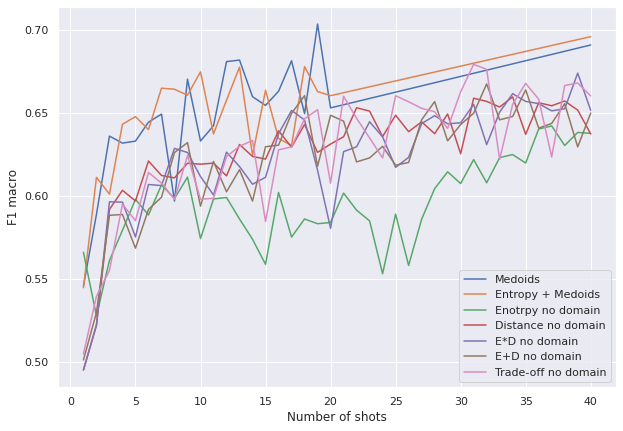

In [ ]:
C = [0.5456164192205039, 0.5889010300179862, 0.6360342722345338, 0.6317917089436703, 0.6330230744546241, 0.6444294855778188, 0.6492899771268552, 0.5968647775423152, 0.6703295528948966, 0.6330589023753935, 0.6422474169751444, 0.6809157495603994, 0.6818567219283881, 0.6597683709545944, 0.6545520794159199, 0.6630402818065794, 0.6814298161924819, 0.649564252071508, 0.70354275782244, 0.6530388264396956, 0.6909346616837311]
MND = [0.5446239170738757, 0.6111779456418054, 0.6010679422898454, 0.6431677679960895, 0.6477561496547607, 0.6399512485917688, 0.6649008322652454, 0.664268971177689, 0.6606601869203652, 0.6747712936834335, 0.637341560717403, 0.6576638751012629, 0.6776092407454591, 0.6244084578990533, 0.6636479339874858, 0.634600469974352, 0.6303872719196427, 0.6779364361096628, 0.6628657915300157, 0.6603980657433659, 0.6959672566561436] # --- 1664.3938796520233 seconds ---
END = [0.5660311253877933, 0.5276372429585481, 0.5610356912497612, 0.579262657228044, 0.5979156473721442, 0.588471117202244, 0.6066037621306168, 0.5984106422414893, 0.61129985718201, 0.5742920361649604, 0.5981293870495145, 0.5990426975807847, 0.586056765415171, 0.5738640824029846, 0.5587151495677171, 0.6020890864944219, 0.5751747250528982, 0.5860909516232408, 0.5832162802815837, 0.5839776827556461, 0.6016744857252262, 0.5913823000098928, 0.5849394899039699, 0.5530713736669367, 0.5890321997140735, 0.5580997579003009, 0.5859070267010825, 0.6043368218945869, 0.6145122104201929, 0.6074270002528074, 0.6218794200444979, 0.6079135563882947, 0.6230711054930664, 0.6248899323362522, 0.6197928959447339, 0.6402940811821234, 0.6421523462416009, 0.6303609208968428, 0.6382406198998204, 0.6376667633154722] # --- 319.17016768455505 seconds ---
DND_shots_7_2 = [0.4950653855941873, 0.5220890022071899, 0.5918406009979115, 0.6033591427562918, 0.5969537461006249, 0.6210235097592997, 0.6123118594229967, 0.6108401425604658, 0.6196806294816086, 0.6191075133993247, 0.6197474697224784, 0.6120654677019665, 0.6309595507517749, 0.623768214626914, 0.6221775708382685, 0.6392324866630655, 0.6293780026605874, 0.6430776461479677, 0.6262186767511979, 0.6312218287129895, 0.6356130350953951, 0.6531285245796437, 0.651086782187324, 0.6357301460840855, 0.6486205835660309, 0.6387073573040859, 0.6446163401676781, 0.6375026238490621, 0.6493665969309713, 0.6253989483812713, 0.658838908710034, 0.6569619842429374, 0.6535355314979059, 0.6596790542855506, 0.6370822181280033, 0.6561294067137766, 0.6543234484235475, 0.6571526999908054, 0.6517077033949643, 0.637336741639989] # --- 348.3936619758606 seconds ---
E4D_ND_shots_7_2 = [0.4950653855941873, 0.5220890022071899, 0.5964506905799117, 0.5962222451137247, 0.5752006016708956, 0.6068579068279306, 0.6062098806029196, 0.6286311963414412, 0.626138906646632, 0.6116757703755932, 0.600490802047292, 0.6263654910113677, 0.6176664870702339, 0.6070283401095222, 0.6111962328767129, 0.6374184250211702, 0.6514964256707253, 0.6457550363749964, 0.6154161594268113, 0.580429891189878, 0.6266604842500313, 0.6295857429186799, 0.6446804322933357, 0.6355512600433597, 0.6171738642248703, 0.6232218892864416, 0.6435616553757902, 0.6483369120739163, 0.6434450884206139, 0.6440420872370757, 0.655126557856821, 0.6309180182825289, 0.650475836651464, 0.6615776943566699, 0.6569316047672256, 0.6556229627610602, 0.6512340053701025, 0.6525128922340847, 0.6739920497505886, 0.6515466663354638] # --- 360.74309182167053 seconds ---
EpD_ND_shots_7_2 = [0.5011480962705191, 0.5296903817038455, 0.5882831996994137, 0.5887986370434802, 0.5684659118234877, 0.5918373089642383, 0.5991698965399815, 0.6261236758816188, 0.6320849430372498, 0.5938080842438154, 0.6207495103690915, 0.6024675378380301, 0.6157812289905967, 0.5968847645147767, 0.6296479755106408, 0.6305501257578964, 0.6497262159172764, 0.6603857500131738, 0.617885753318604, 0.6485730342938201, 0.6450418812002384, 0.6204753645862412, 0.6228996112817227, 0.6298642957598946, 0.6185184523628938, 0.6201280387197908, 0.645841589738353, 0.6568118038393879, 0.6331532166541105, 0.643008577791031, 0.6497773197679606, 0.6674823162086934, 0.645836090455353, 0.6478570623011753, 0.6638914296119286, 0.6408497000348969, 0.643687825525984, 0.6555351636014122, 0.6295368203272995, 0.6499285154671318] # --- 339.1089737415314 seconds ---
T_ND_shots_7_2 = [0.5047536143936433, 0.5394907009046596, 0.5550241372500254, 0.5949936539947688, 0.5850620409680319, 0.6141196507717727, 0.6076873643466928, 0.5979799660967061, 0.6242104828392857, 0.5979821634351478, 0.5985732436907876, 0.6236764040374145, 0.6299019301211503, 0.6333737024136223, 0.5845020438505887, 0.6277743219438656, 0.6295047772366068, 0.6464493577417879, 0.6519457735935298, 0.6076383405232629, 0.6600546669354214, 0.6467580257609813, 0.6349161051991266, 0.6228651059410241, 0.6603735411980749, 0.6567343551745237, 0.6527669464068896, 0.6506945986307026, 0.6406627269103689, 0.6627092395651702, 0.6792701892913259, 0.676244206451796, 0.6220097238191166, 0.6551893868739537, 0.6678052165386706, 0.6582656248175596, 0.6234809885516837, 0.6665182554710604, 0.6680481017471644, 0.6602572335219595] # --- 328.72182178497314 seconds ---
sns.set()
plt.figure(figsize=(10, 7))
plt.plot(centroid_shots, C)
plt.plot(centroid_shots, MND)
plt.plot(shots, END)
plt.plot(shots, DND_shots_7_2)
plt.plot(shots, E4D_ND_shots_7_2)
plt.plot(shots, EpD_ND_shots_7_2)
plt.plot(shots, T_ND_shots_7_2)
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.legend(labels=["Medoids", "Entropy + Medoids", "Enotrpy no domain", "Distance no domain", "E*D no domain", "E+D no domain ", "Trade-off no domain"])
plt.savefig('no_domain.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


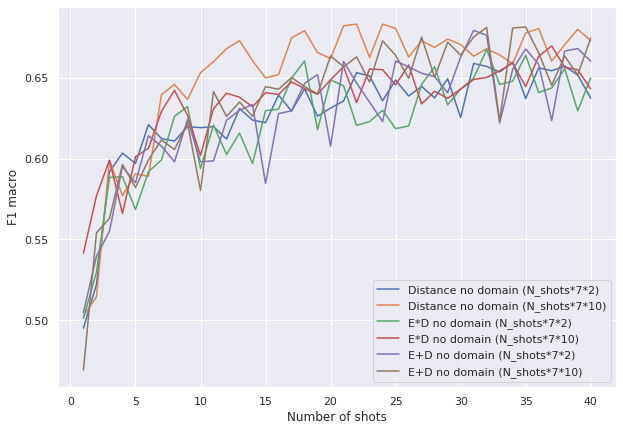

In [ ]:
DND_shots_7_10 = [0.5027393993210539, 0.51442243734782, 0.5988215605344485, 0.5770386946020266, 0.5904954901107431, 0.5889741684118724, 0.6395470967023342, 0.6458610170966975, 0.6365625716738305, 0.6530869915995596, 0.6599547737213712, 0.6679642054635858, 0.6729136266642677, 0.6605102168100191, 0.6498375932654792, 0.6519675860667372, 0.6746241074144299, 0.6790723264206168, 0.6655856324051819, 0.661844507586358, 0.6821426553019301, 0.6831468386936564, 0.6625358957405931, 0.683185030799119, 0.6804866678173888, 0.6628579977791362, 0.6727802600311118, 0.6687690243358676, 0.6739187028744592, 0.6705732917668243, 0.6633108300040568, 0.6678891233127119, 0.6641034103589328, 0.6586369860499885, 0.6777333540823881, 0.6804066217883875, 0.660305162434227, 0.670397937202278, 0.6799274621976432, 0.6729716150324837] # --- 404.5768551826477 seconds ---
DND_shots_7_2 = [0.4950653855941873, 0.5220890022071899, 0.5918406009979115, 0.6033591427562918, 0.5969537461006249, 0.6210235097592997, 0.6123118594229967, 0.6108401425604658, 0.6196806294816086, 0.6191075133993247, 0.6197474697224784, 0.6120654677019665, 0.6309595507517749, 0.623768214626914, 0.6221775708382685, 0.6392324866630655, 0.6293780026605874, 0.6430776461479677, 0.6262186767511979, 0.6312218287129895, 0.6356130350953951, 0.6531285245796437, 0.651086782187324, 0.6357301460840855, 0.6486205835660309, 0.6387073573040859, 0.6446163401676781, 0.6375026238490621, 0.6493665969309713, 0.6253989483812713, 0.658838908710034, 0.6569619842429374, 0.6535355314979059, 0.6596790542855506, 0.6370822181280033, 0.6561294067137766, 0.6543234484235475, 0.6571526999908054, 0.6517077033949643, 0.637336741639989] # --- 348.3936619758606 seconds ---
E4D_ND_shots_7_2 = [0.4950653855941873, 0.5220890022071899, 0.5964506905799117, 0.5962222451137247, 0.5752006016708956, 0.6068579068279306, 0.6062098806029196, 0.6286311963414412, 0.626138906646632, 0.6116757703755932, 0.600490802047292, 0.6263654910113677, 0.6176664870702339, 0.6070283401095222, 0.6111962328767129, 0.6374184250211702, 0.6514964256707253, 0.6457550363749964, 0.6154161594268113, 0.580429891189878, 0.6266604842500313, 0.6295857429186799, 0.6446804322933357, 0.6355512600433597, 0.6171738642248703, 0.6232218892864416, 0.6435616553757902, 0.6483369120739163, 0.6434450884206139, 0.6440420872370757, 0.655126557856821, 0.6309180182825289, 0.650475836651464, 0.6615776943566699, 0.6569316047672256, 0.6556229627610602, 0.6512340053701025, 0.6525128922340847, 0.6739920497505886, 0.6515466663354638] # --- 360.74309182167053 seconds ---
E4D_ND_shots_7_10 = [0.5415181091171125, 0.5768893901879376, 0.596152746542926, 0.5899251732224523, 0.6056166589300004, 0.6245985686765024, 0.6360063909476246, 0.6165520033142612, 0.6182542383292802, 0.6367882504552468, 0.615030460341534, 0.6278480160403833, 0.6338680673511021, 0.6226033371829008, 0.6190255661087258, 0.629106251735271, 0.6465495970954341, 0.651077493893778, 0.6307874149638094, 0.6352996665725149, 0.6339233540402954, 0.6432712590314058, 0.6390964877788742, 0.6473210212300453, 0.6368953102531163, 0.651933301339701, 0.6404808807772188, 0.6305526902062251, 0.6189824004411598, 0.6481868063794686, 0.6535850120352643, 0.6318464092601345, 0.6551931765373574, 0.6561068286045167, 0.6308901309206769, 0.6458630288811223, 0.6479019240501486, 0.6358305604833233, 0.6832392301002145, 0.6509033441536553] # --- 366.34222054481506 seconds ---
EpD_ND_shots_7_2 = [0.5011480962705191, 0.5296903817038455, 0.5882831996994137, 0.5887986370434802, 0.5684659118234877, 0.5918373089642383, 0.5991698965399815, 0.6261236758816188, 0.6320849430372498, 0.5938080842438154, 0.6207495103690915, 0.6024675378380301, 0.6157812289905967, 0.5968847645147767, 0.6296479755106408, 0.6305501257578964, 0.6497262159172764, 0.6603857500131738, 0.617885753318604, 0.6485730342938201, 0.6450418812002384, 0.6204753645862412, 0.6228996112817227, 0.6298642957598946, 0.6185184523628938, 0.6201280387197908, 0.645841589738353, 0.6568118038393879, 0.6331532166541105, 0.643008577791031, 0.6497773197679606, 0.6674823162086934, 0.645836090455353, 0.6478570623011753, 0.6638914296119286, 0.6408497000348969, 0.643687825525984, 0.6555351636014122, 0.6295368203272995, 0.6499285154671318] # --- 339.1089737415314 seconds ---
EpD_ND_shots_7_10 = [0.5415181091171125, 0.5768893901879376, 0.5989901702395363, 0.5660942046006204, 0.6010524470819425, 0.606396687492036, 0.6292242249007126, 0.6421887608278032, 0.6267952686475416, 0.6018551112422614, 0.630783738102072, 0.640459811780081, 0.63794071256939, 0.632048872571025, 0.6407152223815917, 0.6396606621073485, 0.647466184444804, 0.6432426685992949, 0.6397348619748945, 0.6487384944095992, 0.6568786075345139, 0.6345956556154315, 0.6554167493445694, 0.6549506779932626, 0.6455630096251711, 0.6579131627608915, 0.6337777992565312, 0.6415966310755735, 0.6372671942899684, 0.642991616902851, 0.6489132128698429, 0.6501640696280824, 0.6542661467526368, 0.6590589613147608, 0.6445221181215033, 0.6632717881381417, 0.6696472508712527, 0.6564583523737603, 0.6549147172645695, 0.6430566893358509] # --- 366.5519058704376 seconds ---
T_ND_shots_7_2 = [0.5047536143936433, 0.5394907009046596, 0.5550241372500254, 0.5949936539947688, 0.5850620409680319, 0.6141196507717727, 0.6076873643466928, 0.5979799660967061, 0.6242104828392857, 0.5979821634351478, 0.5985732436907876, 0.6236764040374145, 0.6299019301211503, 0.6333737024136223, 0.5845020438505887, 0.6277743219438656, 0.6295047772366068, 0.6464493577417879, 0.6519457735935298, 0.6076383405232629, 0.6600546669354214, 0.6467580257609813, 0.6349161051991266, 0.6228651059410241, 0.6603735411980749, 0.6567343551745237, 0.6527669464068896, 0.6506945986307026, 0.6406627269103689, 0.6627092395651702, 0.6792701892913259, 0.676244206451796, 0.6220097238191166, 0.6551893868739537, 0.6678052165386706, 0.6582656248175596, 0.6234809885516837, 0.6665182554710604, 0.6680481017471644, 0.6602572335219595] # --- 328.72182178497314 seconds ---
T_ND_shots_7_10 = [0.4691958767575065, 0.5540305895556958, 0.5629831259965273, 0.5963675993695322, 0.5820605265369965, 0.5992373858808312, 0.6114898150250022, 0.6055788544377065, 0.6219774560395056, 0.5802919784571767, 0.6414383966743127, 0.6260740684557804, 0.6349598988987559, 0.626129984363879, 0.6445202956845982, 0.6428633358160424, 0.6501110811245875, 0.6445097621015098, 0.6399459656359108, 0.6635193595370356, 0.6567165273887418, 0.6628692909281159, 0.6473228694536771, 0.6728534879424057, 0.6638800709876308, 0.6496511783378314, 0.6751430768797478, 0.6502615723292797, 0.6719483481223308, 0.6639279241124855, 0.6751951745992265, 0.6811286035253988, 0.6234431710094521, 0.6807261156832939, 0.681400362806154, 0.6652702735254933, 0.6453309585284204, 0.6634716897535581, 0.6516483277060364, 0.674537782142414] # --- 368.57590532302856 seconds ---
sns.set()
plt.figure(figsize=(10, 7))
plt.plot(shots, DND_shots_7_2)
plt.plot(shots, DND_shots_7_10)
plt.plot(shots, EpD_ND_shots_7_2)
plt.plot(shots, EpD_ND_shots_7_10)
plt.plot(shots, T_ND_shots_7_2)
plt.plot(shots, T_ND_shots_7_10)
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.legend(labels=["Distance no domain (N_shots*7*2)", "Distance no domain (N_shots*7*10)", "E*D no domain (N_shots*7*2)", "E*D no domain (N_shots*7*10)", "E+D no domain (N_shots*7*2)", "E+D no domain (N_shots*7*10)", "Trade-off no domain (N_shots*7*2)", "Trade-off no domain (N_shots*7*10)"])
plt.savefig('2_vs_10.eps', format='eps')

## ST-raw - Finetune the sentence transformer



In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

test_ids = random.sample(range(0, len(test_dataset)), 2000)
test_ids = sorted(test_ids)

### Test on a single number of shots

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
  
dataframes = medoids(doc_embeddings, 27)
dataframes

In [ ]:
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

finetuned_model = complete_model_finetuning('sentence-transformers/all-mpnet-base-v2', 768, 768, device)

lr = 1e-5
epochs = 3
batch_size = 8

criterion = NContrastiveLoss()

# chose the best optimazer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)
                              
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, momentum=0.9)
training_documents = document_class(dataframes['Abstract'], dataframes['Domain'])
training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True)

In [ ]:
writer = SummaryWriter()

for epoch in range(epochs):

  training_loss = 0

  finetuned_model.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    labels_set = list(labels)
    labels_encoding = finetuned_model(labels_set)
    lab2emb = dict(zip(labels_set, labels_encoding))
    negatives_list = []
    positive_list = []
    for positive in training_labels: # for each training label that is the positive for the considered anchor
      x = [v for k, v in lab2emb.items() if not k == positive] # select all the embeddings of the labels that are different from the positive one
      pos = [v for k, v in lab2emb.items() if k == positive] # select the positive label's embedding
      negatives_list.append(torch.stack(x)) # append in a list the tensor matrices of the negative labels' embeddings
      positive_list.extend(pos) # extend the list containing all the postive embeddings 
    negatives = torch.stack(negatives_list) # cread a 3D tensor matrix (batch_size, num_labels - 1, embedding_dimension)
    positives = torch.stack(positive_list) # create a 2D tensor matrix (batch_size, embedding_dimension)
    negatives = negatives.to(device)
    positives = positives.to(device)
    document_embeddings = finetuned_model(list(docs))
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch+1}/{len(training_dataloader)}, epoch: {epoch+1}/{epochs}. Training loss: {training_loss:.3f}.')
  writer.add_scalar("Loss/epoch", training_loss, epoch+1)

  finetuned_model.eval()
  tmp_test_document_embeddings = []

  with torch.no_grad():
    label_embeddings = finetuned_model(labels)

  test_dataloader = DataLoader(list(test_docs.iloc[test_ids]), batch_size=32, shuffle=False)
  for test_doc in tqdm(test_dataloader):
    with torch.no_grad():
      embs = finetuned_model(test_doc)
    tmp_test_document_embeddings.extend(embs)

  test_document_embeddings = torch.stack(tmp_test_document_embeddings)
  knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
  knn.fit(label_embeddings.cpu(), labels)
  y_pred = knn.predict(test_document_embeddings.cpu())
  selected_elements = [test_labels[index] for index in test_ids]
  F1 = f1_score(selected_elements, y_pred, average='macro')
  print(f'Epoch: {epoch}, F1 macro: {F1}')

#writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

In [ ]:
#!pip install tensorboard
%load_ext tensorboard
%tensorboard --logdir=my_runs

### Test on a range of shots


In [ ]:
def select_few_shots(dfs, shot_selection, N_shots, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5, doc_embeddings = doc_embeddings):
  if shot_selection == "R":
    dataframe = random_selection(dfs, N_shots)
  elif shot_selection == "E":
    dataframe = entropy(dfs, N_shots, threshold)
  elif shot_selection == "D":
    dataframe = distance(dfs, N_shots, threshold)
  elif shot_selection == "E*D":
    dataframe = distance_times_entropy(dfs, N_shots, threshold)
  elif shot_selection == "E+D":
    dataframe = distance_plus_entropy(dfs, N_shots, threshold)
  elif shot_selection == "tradeoff":
    dataframe = tradeoff(dfs, N_shots, threshold, alpha)
  elif shot_selection == "M":
    dataframe = mixed_entropy_random(dfs, N_shots)
  elif shot_selection == "C":
    dataframe = medoids(doc_embeddings, N_shots)
  elif shot_selection == "WD":
    dataframe = medoids_within_domain(dfs, N_shots, doc_embeddings)
  elif shot_selection == "EM":
    dataframe = entropy_and_cenotrids(train_df, N_shots)
  elif shot_selection == "END":
    dataframe = entropy_no_domain(train_df, N_shots)
  elif shot_selection == "DND":
    dataframe = distance_no_domain(train_df, N_shots)
  elif shot_selection == "E*D_ND":
    dataframe = distance_times_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "E+D_ND":
    dataframe = distance_plus_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "tradeoff_ND":
    dataframe = tradeoff_no_domain(train_df, N_shots, threshold, alpha)
  elif shot_selection == "MND":
    dataframe = mixed_entropy_random_no_domain(dfs, N_shots)
  return dataframe

In [ ]:
writer = SummaryWriter()

def finetune_and_test(model, training_epochs, training_dataloader, criterion, optimizer, n_shot):

  for epoch in range(training_epochs):

    training_loss = 0

    model.train()

    for batch, (training_labels, docs) in enumerate(training_dataloader):
      labels_set = list(labels)
      labels_encoding = model(labels_set)
      lab2emb = dict(zip(labels_set, labels_encoding))
      negatives_list = []
      positive_list = []
      for positive in training_labels: # for each training label that is the positive for the considered anchor
        x = [v for k, v in lab2emb.items() if not k == positive] # select all the embeddings of the labels that are different from the positive one
        pos = [v for k, v in lab2emb.items() if k == positive] # select the positive label's embedding
        negatives_list.append(torch.stack(x)) # append in a list the tensor matrices of the negative labels' embeddings
        positive_list.extend(pos) # extend the list containing all the postive embeddings 
      negatives = torch.stack(negatives_list) # cread a 3D tensor matrix (batch_size, num_labels - 1, embedding_dimension)
      positives = torch.stack(positive_list) # create a 2D tensor matrix (batch_size, embedding_dimension)
      negatives = negatives.to(device)
      positives = positives.to(device)
      document_embeddings = model(list(docs))
      loss = criterion(document_embeddings, positives, negatives)
      optimizer.zero_grad()
      loss.backward()
      training_loss += loss
      optimizer.step()

    print(f'Epoch: {epoch}/{training_epochs}. Training loss: {training_loss:.3f}.')
    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

  model.eval()
  tmp_test_document_embeddings = []

  with torch.no_grad():
    label_embeddings = model(labels)

  test_dataloader = DataLoader(list(test_docs.iloc[test_ids]), batch_size=32, shuffle=False)
  for test_doc in tqdm(test_dataloader):
    with torch.no_grad():
      embs = model(test_doc)
    tmp_test_document_embeddings.extend(embs)

  test_document_embeddings = torch.stack(tmp_test_document_embeddings)
  knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
  knn.fit(label_embeddings.cpu(), labels)
  y_pred = knn.predict(test_document_embeddings.cpu())
  selected_elements = [test_labels[index] for index in test_ids]
  F1 = f1_score(selected_elements, y_pred, average='macro')
  print(f'N-shots: {n_shot}, F1 macro: {F1}')

  writer.flush()
  f = open("results_finetuned.txt", "a")
  f.write(f"N-shots: {n_shot}, F1 macro : {F1}\n")
  f.close()
  return F1
writer.flush()

In [ ]:
def finetune_few_shot(dataframes, shot_selection, list_of_shots, epochs, lr, doc_embeddings = doc_embeddings, batch_size = 256, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5):
  f = open("results_finetuned.txt", "a")
  if shot_selection == "R":
    f.write(f"{list_of_shots[-1]} shots - Random: \n")
  elif shot_selection == "E":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only entropy: \n")
  elif shot_selection == "D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only distance: \n")
  elif shot_selection == "E*D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance: \n")
  elif shot_selection == "E+D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance: \n")
  elif shot_selection == "tradeoff":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff: \n")
  elif shot_selection == "M":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random): \n")
  elif shot_selection == "C":
    f.write(f"{list_of_shots[-1]} shots - Centroids: \n")
  elif shot_selection == "WD":
    f.write(f"{list_of_shots[-1]} shots - Within domain centroids: \n")
  elif shot_selection == "EM":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Entropy with Medoids: \n")
  elif shot_selection == "END":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only entropy NO DOMAIN: \n")
  elif shot_selection == "DND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only distance NO DOMAIN: \n") 
  elif shot_selection == "E*D_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance NO DOMAIN: \n")
  elif shot_selection == "E+D_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance NO DOMAIN: \n")
  elif shot_selection == "tradeoff_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff NO DOMAIN: \n")
  elif shot_selection == "MND":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random) NO DOMAIN: \n")
  
  criterion = NContrastiveLoss()
  
  f.close()
  F1s = []
  for N_shots in list_of_shots:

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device == 'cuda':
      torch.cuda.set_device(gpu_no)
      torch.cuda.manual_seed(random_seed)

    data = select_few_shots(dataframes, shot_selection, N_shots, threshold, alpha, doc_embeddings)

    finetuned_model = complete_model_finetuning('sentence-transformers/all-mpnet-base-v2', 768, 768, device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

    training_documents = document_class(data['Abstract'], data['Domain'])
    training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True)

    F1 = finetune_and_test(finetuned_model, epochs, training_dataloader, criterion, optimizer, N_shots)
    F1s.append(F1)

  f = open("results_finetuned.txt", "a")
  f.write(f"F1 scores: {F1s}")
  f.write("\n\n")
  f.close()

In [ ]:
list_of_shots = [1, 3, 6, 9, 12, 15, 27, 40]

In [ ]:
start_time = time.time()
finetune_few_shot(dfs, "tradeoff", list_of_shots, epochs = 3, lr = 1e-5, doc_embeddings=doc_embeddings, batch_size=8)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch: 0/3. Training loss: 1.874.
Epoch: 1/3. Training loss: 1.824.
Epoch: 2/3. Training loss: 1.798.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 1, F1 macro: 0.6375903507626558
Epoch: 0/3. Training loss: 5.537.
Epoch: 1/3. Training loss: 5.277.
Epoch: 2/3. Training loss: 5.113.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 3, F1 macro: 0.6603929800515381
Epoch: 0/3. Training loss: 10.979.
Epoch: 1/3. Training loss: 10.320.
Epoch: 2/3. Training loss: 9.779.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 6, F1 macro: 0.6716920657179497
Epoch: 0/3. Training loss: 14.511.
Epoch: 1/3. Training loss: 13.645.
Epoch: 2/3. Training loss: 12.857.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 9, F1 macro: 0.6555245651970516
Epoch: 0/3. Training loss: 19.951.
Epoch: 1/3. Training loss: 18.519.
Epoch: 2/3. Training loss: 17.401.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 12, F1 macro: 0.6524708757758384
Epoch: 0/3. Training loss: 25.218.
Epoch: 1/3. Training loss: 23.256.
Epoch: 2/3. Training loss: 21.403.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 15, F1 macro: 0.6419257966926617
Epoch: 0/3. Training loss: 42.738.
Epoch: 1/3. Training loss: 38.327.
Epoch: 2/3. Training loss: 35.870.


100%|██████████| 63/63 [01:10<00:00,  1.11s/it]


N-shots: 27, F1 macro: 0.6703672165013659
Epoch: 0/3. Training loss: 60.717.
Epoch: 1/3. Training loss: 53.848.
Epoch: 2/3. Training loss: 50.591.


100%|██████████| 63/63 [01:10<00:00,  1.12s/it]


N-shots: 40, F1 macro: 0.6418142086240195
--- 808.8880593776703 seconds ---


Hyperparameter importance with trade-off selection technique

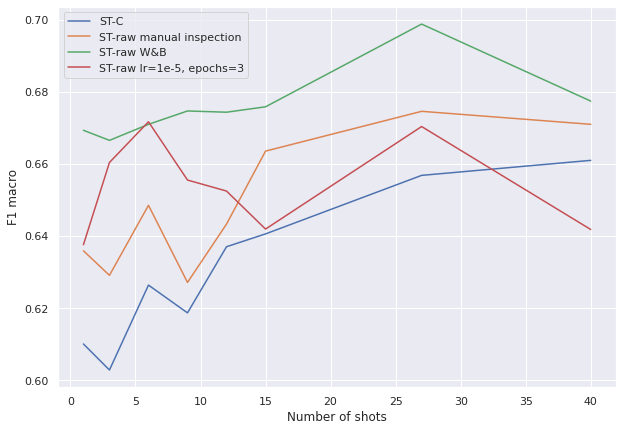

In [ ]:
Tradeoff_classifier = [0.6100590362931035, 0.6028335004445562, 0.6263851694778927, 0.6186832267411777, 0.6370270464346338, 0.6405863755052958, 0.6568215788433731, 0.6609849916941719]
Tradeoff_finetuned_sentence_transformer = [0.6359024709024592, 0.6290934164465943, 0.6485213086155427, 0.6271215246142854, 0.6433097172111603, 0.6635506538000872, 0.6745879090515862, 0.6709849916941719]
wandb_results_2000_docs = [0.6693275019246148, 0.6665355015540825, 0.670980181753486, 0.674684878452179, 0.6743425240376385, 0.675843093679913, 0.698789558444304, 0.6774280019060813]
T_e_5 = [0.6375903507626558, 0.6603929800515381, 0.6716920657179497, 0.6555245651970516, 0.6524708757758384, 0.6419257966926617, 0.6703672165013659, 0.6418142086240195]
sns.set()
plt.figure(figsize=(10, 7))
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.plot([1,3,6,9,12,15,27,40], Tradeoff_classifier)
plt.plot([1,3,6,9,12,15,27,40], Tradeoff_finetuned_sentence_transformer)
plt.plot([1,3,6,9,12, 15, 27, 40], wandb_results_2000_docs)
plt.plot([1,3,6,9,12,15,27,40], T_e_5)
plt.legend(labels=["ST-C", "ST-raw manual inspection", "ST-raw W&B", "ST-raw lr=1e-5, epochs=3"])
plt.savefig('Tradeoff_hyper.eps', format='eps')

Hyperparameter importance with medoids selection technique

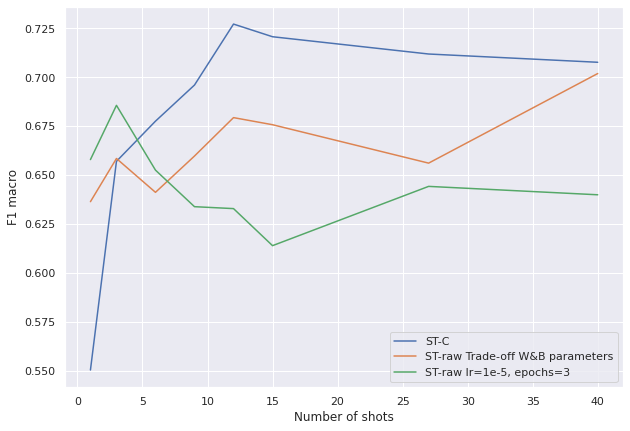

In [ ]:
clusters_2000docs_finetuned = [0.6363392634043313, 0.6583993886863163, 0.6411177426601481, 0.659665421547831, 0.6792865192440131, 0.6756610896120527, 0.6560354341708392, 0.7018137382816135]
clusters_2000docs_classifier = [0.550337621946649, 0.6569487030283442, 0.6774709650518764, 0.6959336378960107, 0.7270817218490687, 0.7206131588014781, 0.7117872508926675, 0.7075670506108188]
C_e_5 = [0.6578446046901673, 0.6855630285466318, 0.6524608785760199, 0.6337843653824288, 0.6328002918045907, 0.6138691245745035, 0.6441543797283631, 0.6398633512388308]
sns.set()
plt.figure(figsize=(10, 7))
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.plot([1,3,6,9,12,15,27,40], clusters_2000docs_classifier)
plt.plot([1,3,6,9,12,15,27,40], clusters_2000docs_finetuned) # come con hyperparam giusti performance può essere molto maggiore, ma vanno adattati a seconda della tecnica usata per selezione shots. e.g. non funzionano con centroidi
plt.plot([1,3,6,9,12,15,27,40], C_e_5)
plt.legend(labels=["ST-C", "ST-raw Trade-off W&B parameters", "ST-raw lr=1e-5, epochs=3"])
plt.savefig('Medoids_hyper.eps', format='eps')

# Standard supervision

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

test_ids = random.sample(range(0, len(test_dataset)), 2000)
test_ids = sorted(test_ids)

In [ ]:
def select_few_shots(dfs, shot_selection, N_shots, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5, doc_embeddings = doc_embeddings):
  if shot_selection == "R":
    dataframe = random_selection(dfs, N_shots)
  elif shot_selection == "E":
    dataframe = entropy(dfs, N_shots, threshold)
  elif shot_selection == "D":
    dataframe = distance(dfs, N_shots, threshold)
  elif shot_selection == "E*D":
    dataframe = distance_times_entropy(dfs, N_shots, threshold)
  elif shot_selection == "E+D":
    dataframe = distance_plus_entropy(dfs, N_shots, threshold)
  elif shot_selection == "tradeoff":
    dataframe = tradeoff(dfs, N_shots, threshold, alpha)
  elif shot_selection == "M":
    dataframe = mixed_entropy_random(dfs, N_shots)
  elif shot_selection == "C":
    dataframe = medoids(doc_embeddings, N_shots)
  elif shot_selection == "WD":
    dataframe = medoids_within_domain(dfs, N_shots, doc_embeddings)
  elif shot_selection == "EM":
    dataframe = entropy_and_cenotrids(train_df, N_shots)
  elif shot_selection == "END":
    dataframe = entropy_no_domain(train_df, N_shots)
  elif shot_selection == "DND":
    dataframe = distance_no_domain(train_df, N_shots)
  elif shot_selection == "E*D_ND":
    dataframe = distance_times_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "E+D_ND":
    dataframe = distance_plus_entropy_no_domain(train_df, N_shots)
  elif shot_selection == "tradeoff_ND":
    dataframe = tradeoff_no_domain(train_df, N_shots, threshold, alpha)
  elif shot_selection == "MND":
    dataframe = mixed_entropy_random_no_domain(dfs, N_shots)
  return dataframe

In [ ]:
test_embeddings = pd.read_csv('/content/drive/MyDrive/test_embeddings.txt', sep = ' ', header=None)
test_embeddings = test_embeddings.astype(np.float32)
test_embeddings = np.asarray(test_embeddings)

In [ ]:
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

In [ ]:
le = LabelEncoder()
ohe = OneHotEncoder(sparse=False)

integer_labels = le.fit_transform(labels)
ohe.fit(integer_labels.reshape(-1,1))

int_test_labels = le.transform(test_labels)
ohe_test_labels = ohe.transform(int_test_labels.reshape(-1,1))

In [ ]:
writer = SummaryWriter()

def train_and_test_supervised_model(supervised_model, epochs, training_dataloader, criterion, optimizer, int_test_labels, test_embeddings, N_shots, classifier = True, batch_size = 256):
  # if classifier = True then the ST-C model is trained, otherwis if classifier = False the ST-raw is fine-tuned
  f = open("supervised_results.txt", "a")
  f.write(f"\nN-Shots: {N_shots}\n")
  for epoch in range(epochs):

    training_loss = 0

    supervised_model.train()

    for batch, (training_labels, docs) in enumerate(training_dataloader):
      training_labels = training_labels.to(device)
      if classifier:
        docs = docs.to(device)
      else:
        docs = list(docs)
      probabilities = supervised_model(docs)
      loss = criterion(probabilities, training_labels)
      training_loss += loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
      writer.add_scalar("Loss/epoch", training_loss, epoch+1)
    if classifier: # if ST-C
      supervised_model.eval()
      dataloader = DataLoader(test_embeddings, batch_size=batch_size, shuffle=False)
      y_pred = []
      for docs in tqdm(dataloader):
        with torch.no_grad():
          docs = docs.to(device)
          y_pred.extend(supervised_model(docs).cpu().numpy())
      F1 = f1_score(int_test_labels, np.argmax(np.asarray(y_pred), axis = 1), average='macro')
      print(f'Epoch: {epoch}, F1 macro: {F1}')
      f.write(f"Epoch: {epoch+1}, F1 macro : {F1} - ")
      writer.add_scalar("F1_macro/epoch", F1, epoch+1)
      if epoch+1 == epochs:
        F1_to_be_saved = F1

  if not classifier: # if ST-raw
    supervised_model.eval()
    dataloader = DataLoader(test_embeddings, batch_size=batch_size, shuffle=False)
    y_pred = []
    for docs in tqdm(dataloader):
      with torch.no_grad():
        y_pred.extend(supervised_model(docs).cpu().numpy())
    F1 = f1_score(int_test_labels, np.argmax(np.asarray(y_pred), axis = 1), average='macro')
    print(f'Epoch: {epoch}, F1 macro: {F1}')
    f.write(f"Epoch: {epoch+1}, F1 macro : {F1} - ")
    writer.add_scalar("F1_macro/epoch", F1, epoch+1)
    if epoch+1 == epochs:
      F1_to_be_saved = F1

  f.close()
  writer.flush()
  return F1_to_be_saved

## ST-C

In [ ]:
def test_few_shot_supervised(sentence_transformer, dataframes, shot_selection, shots, epochs, lr, batch_size = 256, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5, doc_embeddings = doc_embeddings):
  epoch_3 = []
  f = open("supervised_results.txt", "a")
  if shot_selection == "R":
    f.write(f"{shots[-1]} shots - Random:")
  elif shot_selection == "E":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only entropy:")
  elif shot_selection == "D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only distance:")
  elif shot_selection == "E*D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance:")
  elif shot_selection == "E+D":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance:")
  elif shot_selection == "tradeoff":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff:")
  elif shot_selection == "M":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random):")
  elif shot_selection == "C":
    f.write(f"{shots[-1]} shots - Centroids:")
  elif shot_selection == "WD":
    f.write(f"{shots[-1]} shots - Within domain centroids:")
  elif shot_selection == "EM":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Entropy with Medoids:")
  elif shot_selection == "END":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only entropy NO DOMAIN:")
  elif shot_selection == "DND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Only distance NO DOMAIN:") 
  elif shot_selection == "E*D_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance NO DOMAIN:")
  elif shot_selection == "E+D_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance NO DOMAIN:")
  elif shot_selection == "tradeoff_ND":
    f.write(f"{shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff NO DOMAIN:")
  elif shot_selection == "MND":
    f.write(f"{shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random) NO DOMAIN:")

  criterion = torch.nn.CrossEntropyLoss()

  f.close()

  for N_shots in shots:

    print(f"N-SHOTS: {N_shots}")

    data = select_few_shots(dataframes, shot_selection, N_shots, threshold, alpha, doc_embeddings)

    int_training_labels = le.transform(data['Domain'])
    ohe_training_labels = ohe.transform(int_training_labels.reshape(-1,1))

    classifier_supervised = Classifier(768, len(labels), device)

    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_supervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)

    train_emb = sentence_transformer.encode(data['Abstract'], convert_to_tensor=True)
    documents = tuple(zip(ohe_training_labels, np.asarray(train_emb.cpu())))
    training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device == 'cuda':
      torch.cuda.set_device(gpu_no)
      torch.cuda.manual_seed(random_seed)

    F1_3 = train_and_test_supervised_model(classifier_supervised, epochs, training_dataloader, criterion, optimizer, int_test_labels, test_embeddings, N_shots)
    epoch_3.append(F1_3)

  f = open("supervised_results.txt", "a")
  f.write(f"\nEpoch 5 F1 scores: {epoch_3}")
  f.write("\n\n")
  f.close()

In [ ]:
shots = np.arange(40)+1

In [ ]:
centroid_shots = list(np.arange(20)+1)
centroid_shots.extend([40])

In [ ]:
test_few_shot_supervised(model, dfs, "tradeoff", shots, epochs = 3, lr = 1e-2, batch_size = 32, doc_embeddings=doc_embeddings)

N-SHOTS: 1


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0/1, epoch: 0/3. Training loss: 1.937.


100%|██████████| 37/37 [00:00<00:00, 404.47it/s]


Epoch: 0, F1 macro: 0.23551677268469737
Batch: 0/1, epoch: 1/3. Training loss: 1.782.


100%|██████████| 37/37 [00:00<00:00, 571.71it/s]


Epoch: 1, F1 macro: 0.2896376075081845
Batch: 0/1, epoch: 2/3. Training loss: 1.628.


100%|██████████| 37/37 [00:00<00:00, 613.34it/s]


Epoch: 2, F1 macro: 0.31622404885279687
N-SHOTS: 2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0/1, epoch: 0/3. Training loss: 1.926.


100%|██████████| 37/37 [00:00<00:00, 566.82it/s]


Epoch: 0, F1 macro: 0.314069387448662
Batch: 0/1, epoch: 1/3. Training loss: 1.811.


100%|██████████| 37/37 [00:00<00:00, 611.08it/s]


Epoch: 1, F1 macro: 0.3953671454972115
Batch: 0/1, epoch: 2/3. Training loss: 1.686.


100%|██████████| 37/37 [00:00<00:00, 605.00it/s]


Epoch: 2, F1 macro: 0.4342647740623606
N-SHOTS: 3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0/1, epoch: 0/3. Training loss: 1.939.


100%|██████████| 37/37 [00:00<00:00, 601.56it/s]


Epoch: 0, F1 macro: 0.3489762629317678
Batch: 0/1, epoch: 1/3. Training loss: 1.821.


100%|██████████| 37/37 [00:00<00:00, 614.45it/s]


Epoch: 1, F1 macro: 0.45221777047897127
Batch: 0/1, epoch: 2/3. Training loss: 1.724.


100%|██████████| 37/37 [00:00<00:00, 591.15it/s]


Epoch: 2, F1 macro: 0.4966031950524347
N-SHOTS: 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batch: 0/1, epoch: 0/3. Training loss: 1.933.


100%|██████████| 37/37 [00:00<00:00, 598.87it/s]


Epoch: 0, F1 macro: 0.4178772357611574
Batch: 0/1, epoch: 1/3. Training loss: 1.844.


100%|██████████| 37/37 [00:00<00:00, 570.76it/s]


Epoch: 1, F1 macro: 0.5270615275721603
Batch: 0/1, epoch: 2/3. Training loss: 1.726.


100%|██████████| 37/37 [00:00<00:00, 558.67it/s]


Epoch: 2, F1 macro: 0.5613889733613616
N-SHOTS: 5


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0/2, epoch: 0/3. Training loss: 1.941.
Batch: 1/2, epoch: 0/3. Training loss: 3.856.


100%|██████████| 37/37 [00:00<00:00, 594.60it/s]


Epoch: 0, F1 macro: 0.48526141303112535
Batch: 0/2, epoch: 1/3. Training loss: 1.786.
Batch: 1/2, epoch: 1/3. Training loss: 3.566.


100%|██████████| 37/37 [00:00<00:00, 591.48it/s]


Epoch: 1, F1 macro: 0.5309186976432351
Batch: 0/2, epoch: 2/3. Training loss: 1.675.
Batch: 1/2, epoch: 2/3. Training loss: 3.354.


100%|██████████| 37/37 [00:00<00:00, 608.86it/s]


Epoch: 2, F1 macro: 0.5605038190566544
N-SHOTS: 6


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0/2, epoch: 0/3. Training loss: 1.946.
Batch: 1/2, epoch: 0/3. Training loss: 3.848.


100%|██████████| 37/37 [00:00<00:00, 497.40it/s]


Epoch: 0, F1 macro: 0.5161608232454279
Batch: 0/2, epoch: 1/3. Training loss: 1.806.
Batch: 1/2, epoch: 1/3. Training loss: 3.554.


100%|██████████| 37/37 [00:00<00:00, 597.53it/s]


Epoch: 1, F1 macro: 0.5772585284353262
Batch: 0/2, epoch: 2/3. Training loss: 1.678.
Batch: 1/2, epoch: 2/3. Training loss: 3.260.


100%|██████████| 37/37 [00:00<00:00, 611.59it/s]


Epoch: 2, F1 macro: 0.5972059242699842
N-SHOTS: 7


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0/2, epoch: 0/3. Training loss: 1.948.
Batch: 1/2, epoch: 0/3. Training loss: 3.858.


100%|██████████| 37/37 [00:00<00:00, 394.29it/s]


Epoch: 0, F1 macro: 0.5091778883616859
Batch: 0/2, epoch: 1/3. Training loss: 1.805.
Batch: 1/2, epoch: 1/3. Training loss: 3.528.


100%|██████████| 37/37 [00:00<00:00, 378.30it/s]


Epoch: 1, F1 macro: 0.5764147355426622
Batch: 0/2, epoch: 2/3. Training loss: 1.652.
Batch: 1/2, epoch: 2/3. Training loss: 3.276.


100%|██████████| 37/37 [00:00<00:00, 366.38it/s]


Epoch: 2, F1 macro: 0.5900764243942411
N-SHOTS: 8


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0/2, epoch: 0/3. Training loss: 1.949.
Batch: 1/2, epoch: 0/3. Training loss: 3.868.


100%|██████████| 37/37 [00:00<00:00, 598.82it/s]


Epoch: 0, F1 macro: 0.5015277304333722
Batch: 0/2, epoch: 1/3. Training loss: 1.826.
Batch: 1/2, epoch: 1/3. Training loss: 3.569.


100%|██████████| 37/37 [00:00<00:00, 586.35it/s]


Epoch: 1, F1 macro: 0.5955105431284213
Batch: 0/2, epoch: 2/3. Training loss: 1.679.
Batch: 1/2, epoch: 2/3. Training loss: 3.296.


100%|██████████| 37/37 [00:00<00:00, 577.28it/s]


Epoch: 2, F1 macro: 0.6064872936950454
N-SHOTS: 9


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batch: 0/2, epoch: 0/3. Training loss: 1.957.
Batch: 1/2, epoch: 0/3. Training loss: 3.872.


100%|██████████| 37/37 [00:00<00:00, 540.21it/s]


Epoch: 0, F1 macro: 0.5085864405138297
Batch: 0/2, epoch: 1/3. Training loss: 1.821.
Batch: 1/2, epoch: 1/3. Training loss: 3.594.


100%|██████████| 37/37 [00:00<00:00, 531.13it/s]

Epoch: 1, F1 macro: 0.5889202076567371
Batch: 0/2, epoch: 2/3. Training loss: 1.680.


Batch: 1/2, epoch: 2/3. Training loss: 3.330.


100%|██████████| 37/37 [00:00<00:00, 554.05it/s]

Epoch: 2, F1 macro: 0.6074243774030499


N-SHOTS: 10


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0/3, epoch: 0/3. Training loss: 1.959.
Batch: 1/3, epoch: 0/3. Training loss: 3.856.
Batch: 2/3, epoch: 0/3. Training loss: 5.730.


100%|██████████| 37/37 [00:00<00:00, 137.27it/s]


Epoch: 0, F1 macro: 0.5573053518834722
Batch: 0/3, epoch: 1/3. Training loss: 1.762.
Batch: 1/3, epoch: 1/3. Training loss: 3.484.
Batch: 2/3, epoch: 1/3. Training loss: 5.113.


100%|██████████| 37/37 [00:00<00:00, 385.28it/s]


Epoch: 1, F1 macro: 0.6043704576119282
Batch: 0/3, epoch: 2/3. Training loss: 1.589.
Batch: 1/3, epoch: 2/3. Training loss: 3.173.
Batch: 2/3, epoch: 2/3. Training loss: 4.726.


100%|██████████| 37/37 [00:00<00:00, 388.94it/s]


Epoch: 2, F1 macro: 0.6070306171314995
N-SHOTS: 11


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0/3, epoch: 0/3. Training loss: 1.936.
Batch: 1/3, epoch: 0/3. Training loss: 3.847.
Batch: 2/3, epoch: 0/3. Training loss: 5.761.


100%|██████████| 37/37 [00:00<00:00, 397.74it/s]


Epoch: 0, F1 macro: 0.5582821939652524
Batch: 0/3, epoch: 1/3. Training loss: 1.762.
Batch: 1/3, epoch: 1/3. Training loss: 3.491.
Batch: 2/3, epoch: 1/3. Training loss: 5.170.


100%|██████████| 37/37 [00:00<00:00, 394.96it/s]


Epoch: 1, F1 macro: 0.6008227244176222
Batch: 0/3, epoch: 2/3. Training loss: 1.612.
Batch: 1/3, epoch: 2/3. Training loss: 3.180.
Batch: 2/3, epoch: 2/3. Training loss: 4.709.


100%|██████████| 37/37 [00:00<00:00, 408.65it/s]


Epoch: 2, F1 macro: 0.6105369379112479
N-SHOTS: 12


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0/3, epoch: 0/3. Training loss: 1.959.
Batch: 1/3, epoch: 0/3. Training loss: 3.862.
Batch: 2/3, epoch: 0/3. Training loss: 5.748.


100%|██████████| 37/37 [00:00<00:00, 395.95it/s]


Epoch: 0, F1 macro: 0.5791148672252797
Batch: 0/3, epoch: 1/3. Training loss: 1.758.
Batch: 1/3, epoch: 1/3. Training loss: 3.500.
Batch: 2/3, epoch: 1/3. Training loss: 5.172.


100%|██████████| 37/37 [00:00<00:00, 336.18it/s]


Epoch: 1, F1 macro: 0.6204956111270967
Batch: 0/3, epoch: 2/3. Training loss: 1.608.
Batch: 1/3, epoch: 2/3. Training loss: 3.179.
Batch: 2/3, epoch: 2/3. Training loss: 4.673.


100%|██████████| 37/37 [00:00<00:00, 394.90it/s]


Epoch: 2, F1 macro: 0.6277347869628999
N-SHOTS: 13


Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batch: 0/3, epoch: 0/3. Training loss: 1.951.
Batch: 1/3, epoch: 0/3. Training loss: 3.858.
Batch: 2/3, epoch: 0/3. Training loss: 5.753.


100%|██████████| 37/37 [00:00<00:00, 386.78it/s]


Epoch: 0, F1 macro: 0.4737744770392219
Batch: 0/3, epoch: 1/3. Training loss: 1.774.
Batch: 1/3, epoch: 1/3. Training loss: 3.510.
Batch: 2/3, epoch: 1/3. Training loss: 5.216.


100%|██████████| 37/37 [00:00<00:00, 371.99it/s]


Epoch: 1, F1 macro: 0.5727787649091132
Batch: 0/3, epoch: 2/3. Training loss: 1.622.
Batch: 1/3, epoch: 2/3. Training loss: 3.165.
Batch: 2/3, epoch: 2/3. Training loss: 4.755.


100%|██████████| 37/37 [00:00<00:00, 397.41it/s]


Epoch: 2, F1 macro: 0.6011748046849004
N-SHOTS: 14


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch: 0/4, epoch: 0/3. Training loss: 1.945.
Batch: 1/4, epoch: 0/3. Training loss: 3.845.
Batch: 2/4, epoch: 0/3. Training loss: 5.739.
Batch: 3/4, epoch: 0/3. Training loss: 7.582.


100%|██████████| 37/37 [00:00<00:00, 369.54it/s]


Epoch: 0, F1 macro: 0.5738482222976972
Batch: 0/4, epoch: 1/3. Training loss: 1.748.
Batch: 1/4, epoch: 1/3. Training loss: 3.472.
Batch: 2/4, epoch: 1/3. Training loss: 5.131.
Batch: 3/4, epoch: 1/3. Training loss: 6.605.


100%|██████████| 37/37 [00:00<00:00, 400.25it/s]


Epoch: 1, F1 macro: 0.6028522162696174
Batch: 0/4, epoch: 2/3. Training loss: 1.569.
Batch: 1/4, epoch: 2/3. Training loss: 3.117.
Batch: 2/4, epoch: 2/3. Training loss: 4.689.
Batch: 3/4, epoch: 2/3. Training loss: 6.336.


100%|██████████| 37/37 [00:00<00:00, 299.39it/s]


Epoch: 2, F1 macro: 0.6107307704028492
N-SHOTS: 15


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch: 0/4, epoch: 0/3. Training loss: 1.939.
Batch: 1/4, epoch: 0/3. Training loss: 3.867.
Batch: 2/4, epoch: 0/3. Training loss: 5.764.
Batch: 3/4, epoch: 0/3. Training loss: 7.635.


100%|██████████| 37/37 [00:00<00:00, 391.65it/s]


Epoch: 0, F1 macro: 0.5890488905895077
Batch: 0/4, epoch: 1/3. Training loss: 1.758.
Batch: 1/4, epoch: 1/3. Training loss: 3.478.
Batch: 2/4, epoch: 1/3. Training loss: 5.152.
Batch: 3/4, epoch: 1/3. Training loss: 6.780.


100%|██████████| 37/37 [00:00<00:00, 391.08it/s]


Epoch: 1, F1 macro: 0.6281960087176969
Batch: 0/4, epoch: 2/3. Training loss: 1.593.
Batch: 1/4, epoch: 2/3. Training loss: 3.115.
Batch: 2/4, epoch: 2/3. Training loss: 4.642.
Batch: 3/4, epoch: 2/3. Training loss: 6.207.


100%|██████████| 37/37 [00:00<00:00, 408.54it/s]


Epoch: 2, F1 macro: 0.6477083931274057
N-SHOTS: 16


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch: 0/4, epoch: 0/3. Training loss: 1.955.
Batch: 1/4, epoch: 0/3. Training loss: 3.860.
Batch: 2/4, epoch: 0/3. Training loss: 5.729.
Batch: 3/4, epoch: 0/3. Training loss: 7.611.


100%|██████████| 37/37 [00:00<00:00, 607.08it/s]


Epoch: 0, F1 macro: 0.6118363053849439
Batch: 0/4, epoch: 1/3. Training loss: 1.746.
Batch: 1/4, epoch: 1/3. Training loss: 3.427.
Batch: 2/4, epoch: 1/3. Training loss: 5.138.
Batch: 3/4, epoch: 1/3. Training loss: 6.768.


100%|██████████| 37/37 [00:00<00:00, 603.79it/s]


Epoch: 1, F1 macro: 0.6438508652383739
Batch: 0/4, epoch: 2/3. Training loss: 1.557.
Batch: 1/4, epoch: 2/3. Training loss: 3.092.
Batch: 2/4, epoch: 2/3. Training loss: 4.605.
Batch: 3/4, epoch: 2/3. Training loss: 6.119.


100%|██████████| 37/37 [00:00<00:00, 593.13it/s]


Epoch: 2, F1 macro: 0.651124502074184
N-SHOTS: 17


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch: 0/4, epoch: 0/3. Training loss: 1.948.
Batch: 1/4, epoch: 0/3. Training loss: 3.873.
Batch: 2/4, epoch: 0/3. Training loss: 5.755.
Batch: 3/4, epoch: 0/3. Training loss: 7.607.


100%|██████████| 37/37 [00:00<00:00, 544.85it/s]


Epoch: 0, F1 macro: 0.5845971619188403
Batch: 0/4, epoch: 1/3. Training loss: 1.761.
Batch: 1/4, epoch: 1/3. Training loss: 3.453.
Batch: 2/4, epoch: 1/3. Training loss: 5.122.
Batch: 3/4, epoch: 1/3. Training loss: 6.805.


100%|██████████| 37/37 [00:00<00:00, 561.24it/s]

Epoch: 1, F1 macro: 0.6306496897039349
Batch: 0/4, epoch: 2/3. Training loss: 1.589.


Batch: 1/4, epoch: 2/3. Training loss: 3.120.
Batch: 2/4, epoch: 2/3. Training loss: 4.650.
Batch: 3/4, epoch: 2/3. Training loss: 6.108.


100%|██████████| 37/37 [00:00<00:00, 573.39it/s]


Epoch: 2, F1 macro: 0.6436620138481136
N-SHOTS: 18


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batch: 0/4, epoch: 0/3. Training loss: 1.943.
Batch: 1/4, epoch: 0/3. Training loss: 3.868.
Batch: 2/4, epoch: 0/3. Training loss: 5.772.
Batch: 3/4, epoch: 0/3. Training loss: 7.617.


100%|██████████| 37/37 [00:00<00:00, 576.32it/s]


Epoch: 0, F1 macro: 0.5573101479148254
Batch: 0/4, epoch: 1/3. Training loss: 1.779.
Batch: 1/4, epoch: 1/3. Training loss: 3.530.
Batch: 2/4, epoch: 1/3. Training loss: 5.239.
Batch: 3/4, epoch: 1/3. Training loss: 6.869.


100%|██████████| 37/37 [00:00<00:00, 608.59it/s]

Epoch: 1, F1 macro: 0.630928861615316
Batch: 0/4, epoch: 2/3. Training loss: 1.591.
Batch: 1/4, epoch: 2/3. Training loss: 3.169.
Batch: 2/4, epoch: 2/3. Training loss: 4.696.
Batch: 3/4, epoch: 2/3. Training loss: 6.226.



100%|██████████| 37/37 [00:00<00:00, 593.06it/s]


Epoch: 2, F1 macro: 0.6472939514577282
N-SHOTS: 19


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0/5, epoch: 0/3. Training loss: 1.955.
Batch: 1/5, epoch: 0/3. Training loss: 3.882.
Batch: 2/5, epoch: 0/3. Training loss: 5.773.
Batch: 3/5, epoch: 0/3. Training loss: 7.627.
Batch: 4/5, epoch: 0/3. Training loss: 9.480.


100%|██████████| 37/37 [00:00<00:00, 591.59it/s]


Epoch: 0, F1 macro: 0.5946820313155373
Batch: 0/5, epoch: 1/3. Training loss: 1.726.
Batch: 1/5, epoch: 1/3. Training loss: 3.403.
Batch: 2/5, epoch: 1/3. Training loss: 5.101.
Batch: 3/5, epoch: 1/3. Training loss: 6.727.
Batch: 4/5, epoch: 1/3. Training loss: 8.296.


100%|██████████| 37/37 [00:00<00:00, 626.54it/s]

Epoch: 1, F1 macro: 0.6412350601662367
Batch: 0/5, epoch: 2/3. Training loss: 1.554.
Batch: 1/5, epoch: 2/3. Training loss: 3.089.
Batch: 2/5, epoch: 2/3. Training loss: 4.580.
Batch: 3/5, epoch: 2/3. Training loss: 6.047.


Batch: 4/5, epoch: 2/3. Training loss: 7.472.


100%|██████████| 37/37 [00:00<00:00, 609.93it/s]


Epoch: 2, F1 macro: 0.6536287096413126
N-SHOTS: 20


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0/5, epoch: 0/3. Training loss: 1.942.
Batch: 1/5, epoch: 0/3. Training loss: 3.856.
Batch: 2/5, epoch: 0/3. Training loss: 5.737.
Batch: 3/5, epoch: 0/3. Training loss: 7.581.
Batch: 4/5, epoch: 0/3. Training loss: 9.417.


100%|██████████| 37/37 [00:00<00:00, 594.83it/s]


Epoch: 0, F1 macro: 0.619735916672082
Batch: 0/5, epoch: 1/3. Training loss: 1.724.
Batch: 1/5, epoch: 1/3. Training loss: 3.393.
Batch: 2/5, epoch: 1/3. Training loss: 5.050.
Batch: 3/5, epoch: 1/3. Training loss: 6.670.
Batch: 4/5, epoch: 1/3. Training loss: 8.307.


100%|██████████| 37/37 [00:00<00:00, 608.54it/s]

Epoch: 1, F1 macro: 0.65242892218859
Batch: 0/5, epoch: 2/3. Training loss: 1.542.
Batch: 1/5, epoch: 2/3. Training loss: 3.049.
Batch: 2/5, epoch: 2/3. Training loss: 4.492.
Batch: 3/5, epoch: 2/3. Training loss: 5.938.
Batch: 4/5, epoch: 2/3. Training loss: 7.333.



100%|██████████| 37/37 [00:00<00:00, 623.72it/s]


Epoch: 2, F1 macro: 0.6600652731676735
N-SHOTS: 21


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0/5, epoch: 0/3. Training loss: 1.945.
Batch: 1/5, epoch: 0/3. Training loss: 3.874.
Batch: 2/5, epoch: 0/3. Training loss: 5.755.
Batch: 3/5, epoch: 0/3. Training loss: 7.597.
Batch: 4/5, epoch: 0/3. Training loss: 9.486.


100%|██████████| 37/37 [00:00<00:00, 592.44it/s]


Epoch: 0, F1 macro: 0.5770930255354162
Batch: 0/5, epoch: 1/3. Training loss: 1.742.
Batch: 1/5, epoch: 1/3. Training loss: 3.481.
Batch: 2/5, epoch: 1/3. Training loss: 5.109.
Batch: 3/5, epoch: 1/3. Training loss: 6.713.
Batch: 4/5, epoch: 1/3. Training loss: 8.314.


100%|██████████| 37/37 [00:00<00:00, 558.19it/s]

Epoch: 1, F1 macro: 0.6456184003074752


Batch: 0/5, epoch: 2/3. Training loss: 1.571.
Batch: 1/5, epoch: 2/3. Training loss: 3.006.
Batch: 2/5, epoch: 2/3. Training loss: 4.494.
Batch: 3/5, epoch: 2/3. Training loss: 5.881.
Batch: 4/5, epoch: 2/3. Training loss: 7.402.


100%|██████████| 37/37 [00:00<00:00, 590.03it/s]


Epoch: 2, F1 macro: 0.6634344388400375
N-SHOTS: 22


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batch: 0/5, epoch: 0/3. Training loss: 1.931.
Batch: 1/5, epoch: 0/3. Training loss: 3.843.
Batch: 2/5, epoch: 0/3. Training loss: 5.750.
Batch: 3/5, epoch: 0/3. Training loss: 7.628.
Batch: 4/5, epoch: 0/3. Training loss: 9.455.


100%|██████████| 37/37 [00:00<00:00, 549.26it/s]


Epoch: 0, F1 macro: 0.538209799490161
Batch: 0/5, epoch: 1/3. Training loss: 1.737.
Batch: 1/5, epoch: 1/3. Training loss: 3.431.
Batch: 2/5, epoch: 1/3. Training loss: 5.069.
Batch: 3/5, epoch: 1/3. Training loss: 6.682.
Batch: 4/5, epoch: 1/3. Training loss: 8.290.


100%|██████████| 37/37 [00:00<00:00, 599.48it/s]

Epoch: 1, F1 macro: 0.6273194466063368
Batch: 0/5, epoch: 2/3. Training loss: 1.547.
Batch: 1/5, epoch: 2/3. Training loss: 3.045.
Batch: 2/5, epoch: 2/3. Training loss: 4.474.


Batch: 3/5, epoch: 2/3. Training loss: 5.926.
Batch: 4/5, epoch: 2/3. Training loss: 7.363.


100%|██████████| 37/37 [00:00<00:00, 606.50it/s]


Epoch: 2, F1 macro: 0.6433056169634525
N-SHOTS: 23


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batch: 0/6, epoch: 0/3. Training loss: 1.939.
Batch: 1/6, epoch: 0/3. Training loss: 3.847.
Batch: 2/6, epoch: 0/3. Training loss: 5.720.
Batch: 3/6, epoch: 0/3. Training loss: 7.591.
Batch: 4/6, epoch: 0/3. Training loss: 9.420.
Batch: 5/6, epoch: 0/3. Training loss: 11.309.


100%|██████████| 37/37 [00:00<00:00, 217.40it/s]


Epoch: 0, F1 macro: 0.6227622311574452
Batch: 0/6, epoch: 1/3. Training loss: 1.721.
Batch: 1/6, epoch: 1/3. Training loss: 3.427.
Batch: 2/6, epoch: 1/3. Training loss: 5.050.
Batch: 3/6, epoch: 1/3. Training loss: 6.644.
Batch: 4/6, epoch: 1/3. Training loss: 8.224.
Batch: 5/6, epoch: 1/3. Training loss: 9.810.


100%|██████████| 37/37 [00:00<00:00, 165.18it/s]


Epoch: 1, F1 macro: 0.6592609513127249
Batch: 0/6, epoch: 2/3. Training loss: 1.541.
Batch: 1/6, epoch: 2/3. Training loss: 3.049.
Batch: 2/6, epoch: 2/3. Training loss: 4.503.
Batch: 3/6, epoch: 2/3. Training loss: 5.940.
Batch: 4/6, epoch: 2/3. Training loss: 7.409.
Batch: 5/6, epoch: 2/3. Training loss: 8.542.


100%|██████████| 37/37 [00:00<00:00, 211.47it/s]


Epoch: 2, F1 macro: 0.6643283039588525
N-SHOTS: 24


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batch: 0/6, epoch: 0/3. Training loss: 1.950.
Batch: 1/6, epoch: 0/3. Training loss: 3.857.
Batch: 2/6, epoch: 0/3. Training loss: 5.762.
Batch: 3/6, epoch: 0/3. Training loss: 7.634.
Batch: 4/6, epoch: 0/3. Training loss: 9.459.
Batch: 5/6, epoch: 0/3. Training loss: 11.171.


100%|██████████| 37/37 [00:00<00:00, 322.89it/s]


Epoch: 0, F1 macro: 0.6362781885011602
Batch: 0/6, epoch: 1/3. Training loss: 1.704.
Batch: 1/6, epoch: 1/3. Training loss: 3.368.
Batch: 2/6, epoch: 1/3. Training loss: 5.000.
Batch: 3/6, epoch: 1/3. Training loss: 6.641.
Batch: 4/6, epoch: 1/3. Training loss: 8.178.
Batch: 5/6, epoch: 1/3. Training loss: 9.647.


100%|██████████| 37/37 [00:00<00:00, 389.65it/s]


Epoch: 1, F1 macro: 0.6649585014165857
Batch: 0/6, epoch: 2/3. Training loss: 1.472.
Batch: 1/6, epoch: 2/3. Training loss: 2.960.
Batch: 2/6, epoch: 2/3. Training loss: 4.376.
Batch: 3/6, epoch: 2/3. Training loss: 5.814.
Batch: 4/6, epoch: 2/3. Training loss: 7.150.
Batch: 5/6, epoch: 2/3. Training loss: 8.490.


100%|██████████| 37/37 [00:00<00:00, 380.95it/s]


Epoch: 2, F1 macro: 0.6736075380591401
N-SHOTS: 25


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batch: 0/6, epoch: 0/3. Training loss: 1.942.
Batch: 1/6, epoch: 0/3. Training loss: 3.873.
Batch: 2/6, epoch: 0/3. Training loss: 5.761.
Batch: 3/6, epoch: 0/3. Training loss: 7.608.
Batch: 4/6, epoch: 0/3. Training loss: 9.414.
Batch: 5/6, epoch: 0/3. Training loss: 11.177.


100%|██████████| 37/37 [00:00<00:00, 382.32it/s]


Epoch: 0, F1 macro: 0.6444699026421027
Batch: 0/6, epoch: 1/3. Training loss: 1.643.
Batch: 1/6, epoch: 1/3. Training loss: 3.318.
Batch: 2/6, epoch: 1/3. Training loss: 4.949.
Batch: 3/6, epoch: 1/3. Training loss: 6.564.
Batch: 4/6, epoch: 1/3. Training loss: 8.148.
Batch: 5/6, epoch: 1/3. Training loss: 9.581.


100%|██████████| 37/37 [00:00<00:00, 388.88it/s]


Epoch: 1, F1 macro: 0.6698963426504643
Batch: 0/6, epoch: 2/3. Training loss: 1.498.
Batch: 1/6, epoch: 2/3. Training loss: 2.893.
Batch: 2/6, epoch: 2/3. Training loss: 4.245.
Batch: 3/6, epoch: 2/3. Training loss: 5.706.
Batch: 4/6, epoch: 2/3. Training loss: 7.036.
Batch: 5/6, epoch: 2/3. Training loss: 8.363.


100%|██████████| 37/37 [00:00<00:00, 403.76it/s]


Epoch: 2, F1 macro: 0.6814794364346427
N-SHOTS: 26


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batch: 0/6, epoch: 0/3. Training loss: 1.929.
Batch: 1/6, epoch: 0/3. Training loss: 3.836.
Batch: 2/6, epoch: 0/3. Training loss: 5.701.
Batch: 3/6, epoch: 0/3. Training loss: 7.560.
Batch: 4/6, epoch: 0/3. Training loss: 9.417.
Batch: 5/6, epoch: 0/3. Training loss: 11.200.


100%|██████████| 37/37 [00:00<00:00, 385.70it/s]


Epoch: 0, F1 macro: 0.5993851529681339
Batch: 0/6, epoch: 1/3. Training loss: 1.722.
Batch: 1/6, epoch: 1/3. Training loss: 3.357.
Batch: 2/6, epoch: 1/3. Training loss: 4.978.
Batch: 3/6, epoch: 1/3. Training loss: 6.580.
Batch: 4/6, epoch: 1/3. Training loss: 8.143.
Batch: 5/6, epoch: 1/3. Training loss: 9.637.


100%|██████████| 37/37 [00:00<00:00, 385.97it/s]


Epoch: 1, F1 macro: 0.6726553093537184
Batch: 0/6, epoch: 2/3. Training loss: 1.411.
Batch: 1/6, epoch: 2/3. Training loss: 2.863.
Batch: 2/6, epoch: 2/3. Training loss: 4.316.
Batch: 3/6, epoch: 2/3. Training loss: 5.699.
Batch: 4/6, epoch: 2/3. Training loss: 7.127.
Batch: 5/6, epoch: 2/3. Training loss: 8.448.


100%|██████████| 37/37 [00:00<00:00, 393.54it/s]


Epoch: 2, F1 macro: 0.6747112004551991
N-SHOTS: 27


Batches:   0%|          | 0/6 [00:00<?, ?it/s]

Batch: 0/6, epoch: 0/3. Training loss: 1.932.
Batch: 1/6, epoch: 0/3. Training loss: 3.847.
Batch: 2/6, epoch: 0/3. Training loss: 5.760.
Batch: 3/6, epoch: 0/3. Training loss: 7.608.
Batch: 4/6, epoch: 0/3. Training loss: 9.424.
Batch: 5/6, epoch: 0/3. Training loss: 11.206.


100%|██████████| 37/37 [00:00<00:00, 594.56it/s]


Epoch: 0, F1 macro: 0.6443278622107682
Batch: 0/6, epoch: 1/3. Training loss: 1.689.
Batch: 1/6, epoch: 1/3. Training loss: 3.377.
Batch: 2/6, epoch: 1/3. Training loss: 5.021.
Batch: 3/6, epoch: 1/3. Training loss: 6.622.
Batch: 4/6, epoch: 1/3. Training loss: 8.182.
Batch: 5/6, epoch: 1/3. Training loss: 9.694.


100%|██████████| 37/37 [00:00<00:00, 594.50it/s]

Epoch: 1, F1 macro: 0.6751607147602591
Batch: 0/6, epoch: 2/3. Training loss: 1.529.
Batch: 1/6, epoch: 2/3. Training loss: 2.973.


Batch: 2/6, epoch: 2/3. Training loss: 4.371.
Batch: 3/6, epoch: 2/3. Training loss: 5.733.
Batch: 4/6, epoch: 2/3. Training loss: 7.075.
Batch: 5/6, epoch: 2/3. Training loss: 8.486.


100%|██████████| 37/37 [00:00<00:00, 638.72it/s]


Epoch: 2, F1 macro: 0.6772158338029625
N-SHOTS: 28


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batch: 0/7, epoch: 0/3. Training loss: 1.943.
Batch: 1/7, epoch: 0/3. Training loss: 3.848.
Batch: 2/7, epoch: 0/3. Training loss: 5.733.
Batch: 3/7, epoch: 0/3. Training loss: 7.592.
Batch: 4/7, epoch: 0/3. Training loss: 9.430.
Batch: 5/7, epoch: 0/3. Training loss: 11.219.
Batch: 6/7, epoch: 0/3. Training loss: 12.992.


100%|██████████| 37/37 [00:00<00:00, 575.99it/s]


Epoch: 0, F1 macro: 0.6551384103430911
Batch: 0/7, epoch: 1/3. Training loss: 1.663.
Batch: 1/7, epoch: 1/3. Training loss: 3.258.
Batch: 2/7, epoch: 1/3. Training loss: 4.836.
Batch: 3/7, epoch: 1/3. Training loss: 6.476.
Batch: 4/7, epoch: 1/3. Training loss: 8.054.
Batch: 5/7, epoch: 1/3. Training loss: 9.586.
Batch: 6/7, epoch: 1/3. Training loss: 11.212.


100%|██████████| 37/37 [00:00<00:00, 622.88it/s]

Epoch: 1, F1 macro: 0.6676406730432066
Batch: 0/7, epoch: 2/3. Training loss: 1.510.


Batch: 1/7, epoch: 2/3. Training loss: 2.947.
Batch: 2/7, epoch: 2/3. Training loss: 4.292.
Batch: 3/7, epoch: 2/3. Training loss: 5.668.
Batch: 4/7, epoch: 2/3. Training loss: 7.065.
Batch: 5/7, epoch: 2/3. Training loss: 8.383.
Batch: 6/7, epoch: 2/3. Training loss: 9.571.


100%|██████████| 37/37 [00:00<00:00, 635.59it/s]


Epoch: 2, F1 macro: 0.666201929052085
N-SHOTS: 29


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batch: 0/7, epoch: 0/3. Training loss: 1.950.
Batch: 1/7, epoch: 0/3. Training loss: 3.850.
Batch: 2/7, epoch: 0/3. Training loss: 5.726.
Batch: 3/7, epoch: 0/3. Training loss: 7.577.
Batch: 4/7, epoch: 0/3. Training loss: 9.416.
Batch: 5/7, epoch: 0/3. Training loss: 11.232.
Batch: 6/7, epoch: 0/3. Training loss: 13.084.


100%|██████████| 37/37 [00:00<00:00, 592.87it/s]


Epoch: 0, F1 macro: 0.6306789951595038
Batch: 0/7, epoch: 1/3. Training loss: 1.647.
Batch: 1/7, epoch: 1/3. Training loss: 3.289.
Batch: 2/7, epoch: 1/3. Training loss: 4.889.
Batch: 3/7, epoch: 1/3. Training loss: 6.480.
Batch: 4/7, epoch: 1/3. Training loss: 8.045.
Batch: 5/7, epoch: 1/3. Training loss: 9.548.
Batch: 6/7, epoch: 1/3. Training loss: 11.089.


100%|██████████| 37/37 [00:00<00:00, 609.34it/s]

Epoch: 1, F1 macro: 0.6743166553201645
Batch: 0/7, epoch: 2/3. Training loss: 1.450.
Batch: 1/7, epoch: 2/3. Training loss: 2.857.


Batch: 2/7, epoch: 2/3. Training loss: 4.220.
Batch: 3/7, epoch: 2/3. Training loss: 5.596.
Batch: 4/7, epoch: 2/3. Training loss: 6.972.
Batch: 5/7, epoch: 2/3. Training loss: 8.324.
Batch: 6/7, epoch: 2/3. Training loss: 9.605.


100%|██████████| 37/37 [00:00<00:00, 616.44it/s]


Epoch: 2, F1 macro: 0.6767858642988366
N-SHOTS: 30


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batch: 0/7, epoch: 0/3. Training loss: 1.944.
Batch: 1/7, epoch: 0/3. Training loss: 3.843.
Batch: 2/7, epoch: 0/3. Training loss: 5.719.
Batch: 3/7, epoch: 0/3. Training loss: 7.593.
Batch: 4/7, epoch: 0/3. Training loss: 9.382.
Batch: 5/7, epoch: 0/3. Training loss: 11.184.
Batch: 6/7, epoch: 0/3. Training loss: 12.936.


100%|██████████| 37/37 [00:00<00:00, 383.97it/s]


Epoch: 0, F1 macro: 0.6581180308507321
Batch: 0/7, epoch: 1/3. Training loss: 1.633.
Batch: 1/7, epoch: 1/3. Training loss: 3.301.
Batch: 2/7, epoch: 1/3. Training loss: 4.943.
Batch: 3/7, epoch: 1/3. Training loss: 6.520.
Batch: 4/7, epoch: 1/3. Training loss: 8.036.
Batch: 5/7, epoch: 1/3. Training loss: 9.536.
Batch: 6/7, epoch: 1/3. Training loss: 10.985.


100%|██████████| 37/37 [00:00<00:00, 406.98it/s]


Epoch: 1, F1 macro: 0.6696240664077567
Batch: 0/7, epoch: 2/3. Training loss: 1.442.
Batch: 1/7, epoch: 2/3. Training loss: 2.815.
Batch: 2/7, epoch: 2/3. Training loss: 4.164.
Batch: 3/7, epoch: 2/3. Training loss: 5.475.
Batch: 4/7, epoch: 2/3. Training loss: 6.853.
Batch: 5/7, epoch: 2/3. Training loss: 8.236.
Batch: 6/7, epoch: 2/3. Training loss: 9.509.


100%|██████████| 37/37 [00:00<00:00, 349.54it/s]


Epoch: 2, F1 macro: 0.6769476554663872
N-SHOTS: 31


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batch: 0/7, epoch: 0/3. Training loss: 1.945.
Batch: 1/7, epoch: 0/3. Training loss: 3.852.
Batch: 2/7, epoch: 0/3. Training loss: 5.763.
Batch: 3/7, epoch: 0/3. Training loss: 7.590.
Batch: 4/7, epoch: 0/3. Training loss: 9.422.
Batch: 5/7, epoch: 0/3. Training loss: 11.210.
Batch: 6/7, epoch: 0/3. Training loss: 12.944.


100%|██████████| 37/37 [00:00<00:00, 536.00it/s]


Epoch: 0, F1 macro: 0.6491018887380432
Batch: 0/7, epoch: 1/3. Training loss: 1.648.
Batch: 1/7, epoch: 1/3. Training loss: 3.246.
Batch: 2/7, epoch: 1/3. Training loss: 4.845.
Batch: 3/7, epoch: 1/3. Training loss: 6.424.
Batch: 4/7, epoch: 1/3. Training loss: 7.993.
Batch: 5/7, epoch: 1/3. Training loss: 9.524.
Batch: 6/7, epoch: 1/3. Training loss: 11.006.


100%|██████████| 37/37 [00:00<00:00, 547.37it/s]


Epoch: 1, F1 macro: 0.6696511261660211
Batch: 0/7, epoch: 2/3. Training loss: 1.431.
Batch: 1/7, epoch: 2/3. Training loss: 2.801.
Batch: 2/7, epoch: 2/3. Training loss: 4.112.
Batch: 3/7, epoch: 2/3. Training loss: 5.565.
Batch: 4/7, epoch: 2/3. Training loss: 6.904.
Batch: 5/7, epoch: 2/3. Training loss: 8.180.
Batch: 6/7, epoch: 2/3. Training loss: 9.469.


100%|██████████| 37/37 [00:00<00:00, 585.95it/s]


Epoch: 2, F1 macro: 0.6697765405213586
N-SHOTS: 32


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

Batch: 0/7, epoch: 0/3. Training loss: 1.941.
Batch: 1/7, epoch: 0/3. Training loss: 3.851.
Batch: 2/7, epoch: 0/3. Training loss: 5.737.
Batch: 3/7, epoch: 0/3. Training loss: 7.591.
Batch: 4/7, epoch: 0/3. Training loss: 9.415.
Batch: 5/7, epoch: 0/3. Training loss: 11.196.
Batch: 6/7, epoch: 0/3. Training loss: 12.971.


100%|██████████| 37/37 [00:00<00:00, 563.89it/s]


Epoch: 0, F1 macro: 0.6303471861584774
Batch: 0/7, epoch: 1/3. Training loss: 1.651.
Batch: 1/7, epoch: 1/3. Training loss: 3.266.
Batch: 2/7, epoch: 1/3. Training loss: 4.829.
Batch: 3/7, epoch: 1/3. Training loss: 6.397.
Batch: 4/7, epoch: 1/3. Training loss: 7.941.
Batch: 5/7, epoch: 1/3. Training loss: 9.469.
Batch: 6/7, epoch: 1/3. Training loss: 10.990.


100%|██████████| 37/37 [00:00<00:00, 597.33it/s]


Epoch: 1, F1 macro: 0.6632010040630726
Batch: 0/7, epoch: 2/3. Training loss: 1.384.
Batch: 1/7, epoch: 2/3. Training loss: 2.784.
Batch: 2/7, epoch: 2/3. Training loss: 4.134.
Batch: 3/7, epoch: 2/3. Training loss: 5.542.
Batch: 4/7, epoch: 2/3. Training loss: 6.821.
Batch: 5/7, epoch: 2/3. Training loss: 8.086.
Batch: 6/7, epoch: 2/3. Training loss: 9.407.


100%|██████████| 37/37 [00:00<00:00, 602.47it/s]


Epoch: 2, F1 macro: 0.6680346293019521
N-SHOTS: 33


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batch: 0/8, epoch: 0/3. Training loss: 1.935.
Batch: 1/8, epoch: 0/3. Training loss: 3.836.
Batch: 2/8, epoch: 0/3. Training loss: 5.704.
Batch: 3/8, epoch: 0/3. Training loss: 7.562.
Batch: 4/8, epoch: 0/3. Training loss: 9.402.
Batch: 5/8, epoch: 0/3. Training loss: 11.187.
Batch: 6/8, epoch: 0/3. Training loss: 12.942.
Batch: 7/8, epoch: 0/3. Training loss: 14.688.


100%|██████████| 37/37 [00:00<00:00, 559.23it/s]


Epoch: 0, F1 macro: 0.6424432699524455
Batch: 0/8, epoch: 1/3. Training loss: 1.592.
Batch: 1/8, epoch: 1/3. Training loss: 3.206.
Batch: 2/8, epoch: 1/3. Training loss: 4.770.
Batch: 3/8, epoch: 1/3. Training loss: 6.315.
Batch: 4/8, epoch: 1/3. Training loss: 7.879.
Batch: 5/8, epoch: 1/3. Training loss: 9.403.
Batch: 6/8, epoch: 1/3. Training loss: 10.848.
Batch: 7/8, epoch: 1/3. Training loss: 12.319.


100%|██████████| 37/37 [00:00<00:00, 581.60it/s]


Epoch: 1, F1 macro: 0.6693698229717048
Batch: 0/8, epoch: 2/3. Training loss: 1.393.
Batch: 1/8, epoch: 2/3. Training loss: 2.802.
Batch: 2/8, epoch: 2/3. Training loss: 4.123.
Batch: 3/8, epoch: 2/3. Training loss: 5.450.
Batch: 4/8, epoch: 2/3. Training loss: 6.689.
Batch: 5/8, epoch: 2/3. Training loss: 7.945.
Batch: 6/8, epoch: 2/3. Training loss: 9.237.
Batch: 7/8, epoch: 2/3. Training loss: 10.537.


100%|██████████| 37/37 [00:00<00:00, 604.80it/s]


Epoch: 2, F1 macro: 0.6759935882783052
N-SHOTS: 34


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batch: 0/8, epoch: 0/3. Training loss: 1.938.
Batch: 1/8, epoch: 0/3. Training loss: 3.848.
Batch: 2/8, epoch: 0/3. Training loss: 5.745.
Batch: 3/8, epoch: 0/3. Training loss: 7.593.
Batch: 4/8, epoch: 0/3. Training loss: 9.402.
Batch: 5/8, epoch: 0/3. Training loss: 11.223.
Batch: 6/8, epoch: 0/3. Training loss: 12.987.
Batch: 7/8, epoch: 0/3. Training loss: 14.725.


100%|██████████| 37/37 [00:00<00:00, 595.94it/s]


Epoch: 0, F1 macro: 0.6472026413913238
Batch: 0/8, epoch: 1/3. Training loss: 1.604.
Batch: 1/8, epoch: 1/3. Training loss: 3.184.
Batch: 2/8, epoch: 1/3. Training loss: 4.792.
Batch: 3/8, epoch: 1/3. Training loss: 6.358.
Batch: 4/8, epoch: 1/3. Training loss: 7.835.
Batch: 5/8, epoch: 1/3. Training loss: 9.300.
Batch: 6/8, epoch: 1/3. Training loss: 10.780.
Batch: 7/8, epoch: 1/3. Training loss: 12.200.


100%|██████████| 37/37 [00:00<00:00, 628.82it/s]


Epoch: 1, F1 macro: 0.6753773573692932
Batch: 0/8, epoch: 2/3. Training loss: 1.317.
Batch: 1/8, epoch: 2/3. Training loss: 2.660.
Batch: 2/8, epoch: 2/3. Training loss: 4.073.
Batch: 3/8, epoch: 2/3. Training loss: 5.401.
Batch: 4/8, epoch: 2/3. Training loss: 6.602.
Batch: 5/8, epoch: 2/3. Training loss: 7.888.
Batch: 6/8, epoch: 2/3. Training loss: 9.141.
Batch: 7/8, epoch: 2/3. Training loss: 10.326.


100%|██████████| 37/37 [00:00<00:00, 619.84it/s]


Epoch: 2, F1 macro: 0.6811670065995923
N-SHOTS: 35


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batch: 0/8, epoch: 0/3. Training loss: 1.952.
Batch: 1/8, epoch: 0/3. Training loss: 3.849.
Batch: 2/8, epoch: 0/3. Training loss: 5.753.
Batch: 3/8, epoch: 0/3. Training loss: 7.595.
Batch: 4/8, epoch: 0/3. Training loss: 9.420.
Batch: 5/8, epoch: 0/3. Training loss: 11.171.
Batch: 6/8, epoch: 0/3. Training loss: 12.926.
Batch: 7/8, epoch: 0/3. Training loss: 14.649.


100%|██████████| 37/37 [00:00<00:00, 579.38it/s]


Epoch: 0, F1 macro: 0.65964839992131
Batch: 0/8, epoch: 1/3. Training loss: 1.625.
Batch: 1/8, epoch: 1/3. Training loss: 3.209.
Batch: 2/8, epoch: 1/3. Training loss: 4.828.
Batch: 3/8, epoch: 1/3. Training loss: 6.372.
Batch: 4/8, epoch: 1/3. Training loss: 7.906.
Batch: 5/8, epoch: 1/3. Training loss: 9.392.
Batch: 6/8, epoch: 1/3. Training loss: 10.827.
Batch: 7/8, epoch: 1/3. Training loss: 12.195.


100%|██████████| 37/37 [00:00<00:00, 603.07it/s]


Epoch: 1, F1 macro: 0.6711949180978284
Batch: 0/8, epoch: 2/3. Training loss: 1.413.
Batch: 1/8, epoch: 2/3. Training loss: 2.666.
Batch: 2/8, epoch: 2/3. Training loss: 3.993.
Batch: 3/8, epoch: 2/3. Training loss: 5.368.
Batch: 4/8, epoch: 2/3. Training loss: 6.605.
Batch: 5/8, epoch: 2/3. Training loss: 7.883.
Batch: 6/8, epoch: 2/3. Training loss: 9.086.
Batch: 7/8, epoch: 2/3. Training loss: 10.313.


100%|██████████| 37/37 [00:00<00:00, 624.55it/s]


Epoch: 2, F1 macro: 0.6759351701788807
N-SHOTS: 36


Batches:   0%|          | 0/8 [00:00<?, ?it/s]

Batch: 0/8, epoch: 0/3. Training loss: 1.938.
Batch: 1/8, epoch: 0/3. Training loss: 3.837.
Batch: 2/8, epoch: 0/3. Training loss: 5.716.
Batch: 3/8, epoch: 0/3. Training loss: 7.573.
Batch: 4/8, epoch: 0/3. Training loss: 9.402.
Batch: 5/8, epoch: 0/3. Training loss: 11.191.
Batch: 6/8, epoch: 0/3. Training loss: 12.951.
Batch: 7/8, epoch: 0/3. Training loss: 14.680.


100%|██████████| 37/37 [00:00<00:00, 190.56it/s]


Epoch: 0, F1 macro: 0.6437105262568009
Batch: 0/8, epoch: 1/3. Training loss: 1.633.
Batch: 1/8, epoch: 1/3. Training loss: 3.260.
Batch: 2/8, epoch: 1/3. Training loss: 4.909.
Batch: 3/8, epoch: 1/3. Training loss: 6.388.
Batch: 4/8, epoch: 1/3. Training loss: 7.943.
Batch: 5/8, epoch: 1/3. Training loss: 9.376.
Batch: 6/8, epoch: 1/3. Training loss: 10.826.
Batch: 7/8, epoch: 1/3. Training loss: 12.206.


100%|██████████| 37/37 [00:00<00:00, 199.43it/s]


Epoch: 1, F1 macro: 0.6684176304566897
Batch: 0/8, epoch: 2/3. Training loss: 1.356.
Batch: 1/8, epoch: 2/3. Training loss: 2.692.
Batch: 2/8, epoch: 2/3. Training loss: 4.001.
Batch: 3/8, epoch: 2/3. Training loss: 5.396.
Batch: 4/8, epoch: 2/3. Training loss: 6.726.
Batch: 5/8, epoch: 2/3. Training loss: 7.938.
Batch: 6/8, epoch: 2/3. Training loss: 9.174.
Batch: 7/8, epoch: 2/3. Training loss: 10.393.


100%|██████████| 37/37 [00:00<00:00, 228.56it/s]


Epoch: 2, F1 macro: 0.6759215885403557
N-SHOTS: 37


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batch: 0/9, epoch: 0/3. Training loss: 1.951.
Batch: 1/9, epoch: 0/3. Training loss: 3.863.
Batch: 2/9, epoch: 0/3. Training loss: 5.742.
Batch: 3/9, epoch: 0/3. Training loss: 7.597.
Batch: 4/9, epoch: 0/3. Training loss: 9.397.
Batch: 5/9, epoch: 0/3. Training loss: 11.224.
Batch: 6/9, epoch: 0/3. Training loss: 12.966.
Batch: 7/9, epoch: 0/3. Training loss: 14.689.
Batch: 8/9, epoch: 0/3. Training loss: 16.353.


100%|██████████| 37/37 [00:00<00:00, 374.37it/s]


Epoch: 0, F1 macro: 0.6249149540740256
Batch: 0/9, epoch: 1/3. Training loss: 1.639.
Batch: 1/9, epoch: 1/3. Training loss: 3.191.
Batch: 2/9, epoch: 1/3. Training loss: 4.763.
Batch: 3/9, epoch: 1/3. Training loss: 6.296.
Batch: 4/9, epoch: 1/3. Training loss: 7.791.
Batch: 5/9, epoch: 1/3. Training loss: 9.264.
Batch: 6/9, epoch: 1/3. Training loss: 10.714.
Batch: 7/9, epoch: 1/3. Training loss: 12.077.
Batch: 8/9, epoch: 1/3. Training loss: 13.635.


100%|██████████| 37/37 [00:00<00:00, 311.03it/s]


Epoch: 1, F1 macro: 0.6688755680523111
Batch: 0/9, epoch: 2/3. Training loss: 1.359.
Batch: 1/9, epoch: 2/3. Training loss: 2.613.
Batch: 2/9, epoch: 2/3. Training loss: 3.941.
Batch: 3/9, epoch: 2/3. Training loss: 5.285.
Batch: 4/9, epoch: 2/3. Training loss: 6.558.
Batch: 5/9, epoch: 2/3. Training loss: 7.765.
Batch: 6/9, epoch: 2/3. Training loss: 9.022.
Batch: 7/9, epoch: 2/3. Training loss: 10.315.
Batch: 8/9, epoch: 2/3. Training loss: 12.112.


100%|██████████| 37/37 [00:00<00:00, 381.88it/s]


Epoch: 2, F1 macro: 0.6775878706168773
N-SHOTS: 38


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batch: 0/9, epoch: 0/3. Training loss: 1.944.
Batch: 1/9, epoch: 0/3. Training loss: 3.850.
Batch: 2/9, epoch: 0/3. Training loss: 5.730.
Batch: 3/9, epoch: 0/3. Training loss: 7.586.
Batch: 4/9, epoch: 0/3. Training loss: 9.393.
Batch: 5/9, epoch: 0/3. Training loss: 11.163.
Batch: 6/9, epoch: 0/3. Training loss: 12.937.
Batch: 7/9, epoch: 0/3. Training loss: 14.664.
Batch: 8/9, epoch: 0/3. Training loss: 16.340.


100%|██████████| 37/37 [00:00<00:00, 302.78it/s]

Epoch: 0, F1 macro: 0.660691326919616


Batch: 0/9, epoch: 1/3. Training loss: 1.600.
Batch: 1/9, epoch: 1/3. Training loss: 3.173.
Batch: 2/9, epoch: 1/3. Training loss: 4.734.
Batch: 3/9, epoch: 1/3. Training loss: 6.292.
Batch: 4/9, epoch: 1/3. Training loss: 7.735.
Batch: 5/9, epoch: 1/3. Training loss: 9.203.
Batch: 6/9, epoch: 1/3. Training loss: 10.640.
Batch: 7/9, epoch: 1/3. Training loss: 12.077.
Batch: 8/9, epoch: 1/3. Training loss: 13.507.


100%|██████████| 37/37 [00:00<00:00, 382.37it/s]


Epoch: 1, F1 macro: 0.6743988109298106
Batch: 0/9, epoch: 2/3. Training loss: 1.371.
Batch: 1/9, epoch: 2/3. Training loss: 2.725.
Batch: 2/9, epoch: 2/3. Training loss: 4.070.
Batch: 3/9, epoch: 2/3. Training loss: 5.326.
Batch: 4/9, epoch: 2/3. Training loss: 6.592.
Batch: 5/9, epoch: 2/3. Training loss: 7.726.
Batch: 6/9, epoch: 2/3. Training loss: 8.911.
Batch: 7/9, epoch: 2/3. Training loss: 10.146.
Batch: 8/9, epoch: 2/3. Training loss: 11.306.


100%|██████████| 37/37 [00:00<00:00, 294.39it/s]


Epoch: 2, F1 macro: 0.6829223861006656
N-SHOTS: 39


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batch: 0/9, epoch: 0/3. Training loss: 1.931.
Batch: 1/9, epoch: 0/3. Training loss: 3.837.
Batch: 2/9, epoch: 0/3. Training loss: 5.721.
Batch: 3/9, epoch: 0/3. Training loss: 7.566.
Batch: 4/9, epoch: 0/3. Training loss: 9.387.
Batch: 5/9, epoch: 0/3. Training loss: 11.183.
Batch: 6/9, epoch: 0/3. Training loss: 12.957.
Batch: 7/9, epoch: 0/3. Training loss: 14.673.
Batch: 8/9, epoch: 0/3. Training loss: 16.403.


100%|██████████| 37/37 [00:00<00:00, 370.57it/s]


Epoch: 0, F1 macro: 0.6481643796091078
Batch: 0/9, epoch: 1/3. Training loss: 1.622.
Batch: 1/9, epoch: 1/3. Training loss: 3.193.
Batch: 2/9, epoch: 1/3. Training loss: 4.770.
Batch: 3/9, epoch: 1/3. Training loss: 6.304.
Batch: 4/9, epoch: 1/3. Training loss: 7.787.
Batch: 5/9, epoch: 1/3. Training loss: 9.201.
Batch: 6/9, epoch: 1/3. Training loss: 10.656.
Batch: 7/9, epoch: 1/3. Training loss: 12.052.
Batch: 8/9, epoch: 1/3. Training loss: 13.469.


100%|██████████| 37/37 [00:00<00:00, 405.58it/s]


Epoch: 1, F1 macro: 0.6796760738969425
Batch: 0/9, epoch: 2/3. Training loss: 1.339.
Batch: 1/9, epoch: 2/3. Training loss: 2.646.
Batch: 2/9, epoch: 2/3. Training loss: 3.855.
Batch: 3/9, epoch: 2/3. Training loss: 5.098.
Batch: 4/9, epoch: 2/3. Training loss: 6.370.
Batch: 5/9, epoch: 2/3. Training loss: 7.658.
Batch: 6/9, epoch: 2/3. Training loss: 8.906.
Batch: 7/9, epoch: 2/3. Training loss: 10.055.
Batch: 8/9, epoch: 2/3. Training loss: 11.310.


100%|██████████| 37/37 [00:00<00:00, 393.78it/s]


Epoch: 2, F1 macro: 0.678138233343424
N-SHOTS: 40


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

Batch: 0/9, epoch: 0/3. Training loss: 1.940.
Batch: 1/9, epoch: 0/3. Training loss: 3.857.
Batch: 2/9, epoch: 0/3. Training loss: 5.735.
Batch: 3/9, epoch: 0/3. Training loss: 7.586.
Batch: 4/9, epoch: 0/3. Training loss: 9.410.
Batch: 5/9, epoch: 0/3. Training loss: 11.187.
Batch: 6/9, epoch: 0/3. Training loss: 12.950.
Batch: 7/9, epoch: 0/3. Training loss: 14.694.
Batch: 8/9, epoch: 0/3. Training loss: 16.422.


100%|██████████| 37/37 [00:00<00:00, 381.60it/s]


Epoch: 0, F1 macro: 0.6395111185875191
Batch: 0/9, epoch: 1/3. Training loss: 1.599.
Batch: 1/9, epoch: 1/3. Training loss: 3.147.
Batch: 2/9, epoch: 1/3. Training loss: 4.695.
Batch: 3/9, epoch: 1/3. Training loss: 6.186.
Batch: 4/9, epoch: 1/3. Training loss: 7.713.
Batch: 5/9, epoch: 1/3. Training loss: 9.155.
Batch: 6/9, epoch: 1/3. Training loss: 10.622.
Batch: 7/9, epoch: 1/3. Training loss: 12.050.
Batch: 8/9, epoch: 1/3. Training loss: 13.471.


100%|██████████| 37/37 [00:00<00:00, 378.20it/s]


Epoch: 1, F1 macro: 0.6759101300959894
Batch: 0/9, epoch: 2/3. Training loss: 1.300.
Batch: 1/9, epoch: 2/3. Training loss: 2.653.
Batch: 2/9, epoch: 2/3. Training loss: 3.931.
Batch: 3/9, epoch: 2/3. Training loss: 5.153.
Batch: 4/9, epoch: 2/3. Training loss: 6.494.
Batch: 5/9, epoch: 2/3. Training loss: 7.698.
Batch: 6/9, epoch: 2/3. Training loss: 8.922.
Batch: 7/9, epoch: 2/3. Training loss: 10.128.
Batch: 8/9, epoch: 2/3. Training loss: 11.230.


100%|██████████| 37/37 [00:00<00:00, 380.81it/s]

Epoch: 2, F1 macro: 0.6814677039908693


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


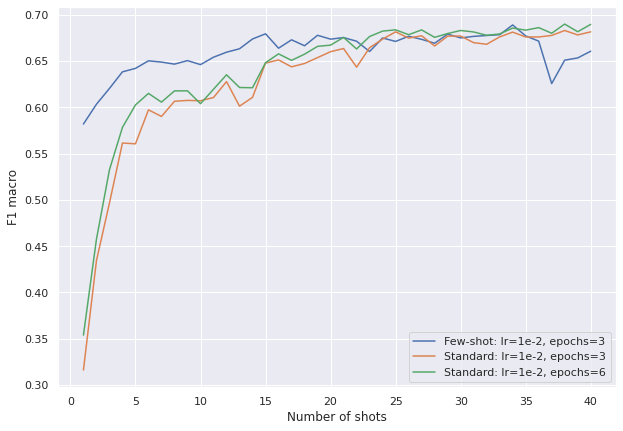

In [ ]:
unsupervised_tradeoff = [0.5818956533815071, 0.6032711752032415, 0.6203351353815333, 0.6382738738087782, 0.6419960266268386, 0.6501714836831881, 0.6487886517160945, 0.6465830924796411, 0.6503994886069479, 0.6460665554681669, 0.654072387695462, 0.6594777654464334, 0.6631914194930187, 0.6737629075259594, 0.6793543558278471, 0.6637914088483334, 0.6728507123301622, 0.6664382705051001, 0.6777442055230882, 0.673576435259022, 0.675274981128822, 0.6713581961622402, 0.6602059620306292, 0.6748173629407243, 0.6711097309381872, 0.676685283676575, 0.6733495239078543, 0.6691578231954844, 0.6789912992202795, 0.6749089617498916, 0.6765717034760395, 0.677511559445825, 0.6783809606540102, 0.6889161696043108, 0.677083989223115, 0.6714517528134366, 0.6255722090964703, 0.6508685016293956, 0.6532937234293021, 0.6605563093095391]
supervised_tradeoff_lr_e_2_6ep = [0.35390620417897595, 0.45747730860083224, 0.5325156591512262, 0.5783332795153514, 0.6024941394832538, 0.6149920111540919, 0.6055609446441751, 0.6176864175604886, 0.617761210347334, 0.6038903144609008, 0.619468366903649, 0.635078419159596, 0.6213565192071343, 0.6210879003875936, 0.6481587442490708, 0.6576859151559195, 0.6506758039185765, 0.6573592579247048, 0.6657897136756095, 0.6671101840615021, 0.6754613001521623, 0.6629813013747956, 0.6764385713586707, 0.6822623353060026, 0.6836347088396401, 0.6784187744063208, 0.6835557895217789, 0.6755449147756061, 0.6796363055066498, 0.6829420548055619, 0.6813218968956425, 0.6777635930337261, 0.6791814980900808, 0.6855317597345485, 0.683298486466032, 0.6860222094416292, 0.6799740489852079, 0.6898553291227911, 0.6815843043172659, 0.6895368833362027]
supervised_tradeoff_lr_e_2_3ep = [0.31622404885279687, 0.4342647740623606, 0.4966031950524347, 0.5613889733613616, 0.5605038190566544, 0.5972059242699842, 0.5900764243942411, 0.6064872936950454, 0.6074243774030499, 0.6070306171314995, 0.6105369379112479, 0.6277347869628999, 0.6011748046849004, 0.6107307704028492, 0.6477083931274057, 0.651124502074184, 0.6436620138481136, 0.6472939514577282, 0.6536287096413126, 0.6600652731676735, 0.6634344388400375, 0.6433056169634525, 0.6643283039588525, 0.6736075380591401, 0.6814794364346427, 0.6747112004551991, 0.6772158338029625, 0.666201929052085, 0.6767858642988366, 0.6769476554663872, 0.6697765405213586, 0.6680346293019521, 0.6759935882783052, 0.6811670065995923, 0.6759351701788807, 0.6759215885403557, 0.6775878706168773, 0.6829223861006656, 0.678138233343424, 0.6814677039908693]
sns.set()
plt.figure(figsize=(10, 7))
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.plot(shots, unsupervised_tradeoff)
plt.plot(shots, supervised_tradeoff_lr_e_2_3ep)
plt.plot(shots, supervised_tradeoff_lr_e_2_6ep)
plt.legend(labels=["Few-shot: lr=1e-2, epochs=3", "Standard: lr=1e-2, epochs=3", "Standard: lr=1e-2, epochs=6"])
plt.savefig('Supervised_tradeoff_cl.eps', format='eps')

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

## ST-raw

In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

test_ids = random.sample(range(0, len(test_dataset)), 2000)
test_ids = sorted(test_ids)

In [ ]:
int_test_lab = [int_test_labels[index] for index in test_ids]
test_documents = test_docs.iloc[test_ids]

In [ ]:
def finetune_few_shot_supervised(dataframes, shot_selection, list_of_shots, epochs, lr, doc_embeddings = doc_embeddings, batch_size = 256, threshold = 0.8, alpha = 0.7, lower_threshold = 0.5):
  f = open("supervised_results.txt", "a")
  if shot_selection == "R":
    f.write(f"{list_of_shots[-1]} shots - Random: \n")
  elif shot_selection == "E":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only entropy: \n")
  elif shot_selection == "D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only distance: \n")
  elif shot_selection == "E*D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance: \n")
  elif shot_selection == "E+D":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance: \n")
  elif shot_selection == "tradeoff":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff: \n")
  elif shot_selection == "M":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random): \n")
  elif shot_selection == "C":
    f.write(f"{list_of_shots[-1]} shots - Centroids: \n")
  elif shot_selection == "WD":
    f.write(f"{list_of_shots[-1]} shots - Within domain centroids: \n")
  elif shot_selection == "EM":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Entropy with Medoids: \n")
  elif shot_selection == "END":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only entropy NO DOMAIN: \n")
  elif shot_selection == "DND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Only distance NO DOMAIN: \n") 
  elif shot_selection == "E*D_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy * Distance NO DOMAIN: \n")
  elif shot_selection == "E+D_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Entropy + Distance NO DOMAIN: \n")
  elif shot_selection == "tradeoff_ND":
    f.write(f"{list_of_shots[-1]} shots - Entropy threshold: {threshold} - Alpha: {alpha} - Tradeoff NO DOMAIN: \n")
  elif shot_selection == "MND":
    f.write(f"{list_of_shots[-1]} shots - Entropy upper threshold: {threshold} - Entropy lower threshold: {lower_threshold} - Mixed (Entropy with Random) NO DOMAIN: \n")

  criterion = torch.nn.CrossEntropyLoss()

  f.close()
  F1s = []
  for N_shots in list_of_shots:

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device == 'cuda':
      torch.cuda.set_device(gpu_no)
      torch.cuda.manual_seed(random_seed)

    data = select_few_shots(dataframes, shot_selection, N_shots, threshold, alpha, doc_embeddings)

    int_top_1_labels = le.transform(data['Domain'])
    ohe_top_1_labels = ohe.transform(int_top_1_labels.reshape(-1,1)) # (32889, 7)

    supervised_finetuned_model = CompleteModelFinetuningWithClassifier('sentence-transformers/all-mpnet-base-v2', 768, len(labels), device)

    # optimizer = optim.SGD([
    #               {'params': finetuned_model.st.parameters()},
    #               {'params': finetuned_model.dropout.parameters()},
    #               {'params': finetuned_model.classification.parameters(), 'lr': 1e-3}
    #           ], lr=lr, momentum=0.9)

    optimizer = optim.Adam([{'params': supervised_finetuned_model.st.parameters()},
                          {'params': supervised_finetuned_model.dropout.parameters()},
                          {'params': supervised_finetuned_model.classification.parameters(), 'lr': 1e-3}],
                          lr=lr, betas = [0.9, 0.999], eps=1e-8)
    
    training_documents = tuple(zip(ohe_top_1_labels, data['Abstract']))
    training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True)

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if device == 'cuda':
      torch.cuda.set_device(gpu_no)
      torch.cuda.manual_seed(random_seed)

    F1 = train_and_test_supervised_model(supervised_finetuned_model, epochs, training_dataloader, criterion, optimizer, int_test_lab, test_documents.values, N_shots, False, 32)
    F1s.append(F1)


  f = open("supervised_results.txt", "a")
  f.write(f"F1 scores: {F1s}")
  f.write("\n\n")
  f.close()

In [ ]:
list_of_shots = [1, 3, 6, 9, 12, 15, 27, 40]

In [ ]:
finetune_few_shot_supervised(dfs, "tradeoff", list_of_shots, epochs = 3, lr = 1e-5, doc_embeddings=doc_embeddings, batch_size=8)

Batch: 0/1, epoch: 0/3. Training loss: 1.947.
Batch: 0/1, epoch: 1/3. Training loss: 1.922.
Batch: 0/1, epoch: 2/3. Training loss: 1.883.


100%|██████████| 63/63 [01:09<00:00,  1.11s/it]
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

Epoch: 2, F1 macro: 0.21523849430824055
Batch: 0/3, epoch: 0/3. Training loss: 1.955.
Batch: 1/3, epoch: 0/3. Training loss: 3.897.
Batch: 2/3, epoch: 0/3. Training loss: 5.860.
Batch: 0/3, epoch: 1/3. Training loss: 1.894.
Batch: 1/3, epoch: 1/3. Training loss: 3.804.
Batch: 2/3, epoch: 1/3. Training loss: 5.648.
Batch: 0/3, epoch: 2/3. Training loss: 1.864.
Batch: 1/3, epoch: 2/3. Training loss: 3.735.
Batch: 2/3, epoch: 2/3. Training loss: 5.592.


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Epoch: 2, F1 macro: 0.2859506167887079
Batch: 0/6, epoch: 0/3. Training loss: 1.944.
Batch: 1/6, epoch: 0/3. Training loss: 3.903.
Batch: 2/6, epoch: 0/3. Training loss: 5.811.
Batch: 3/6, epoch: 0/3. Training loss: 7.773.
Batch: 4/6, epoch: 0/3. Training loss: 9.694.
Batch: 5/6, epoch: 0/3. Training loss: 11.637.
Batch: 0/6, epoch: 1/3. Training loss: 1.917.
Batch: 1/6, epoch: 1/3. Training loss: 3.789.
Batch: 2/6, epoch: 1/3. Training loss: 5.648.
Batch: 3/6, epoch: 1/3. Training loss: 7.533.
Batch: 4/6, epoch: 1/3. Training loss: 9.414.
Batch: 5/6, epoch: 1/3. Training loss: 11.289.
Batch: 0/6, epoch: 2/3. Training loss: 1.846.
Batch: 1/6, epoch: 2/3. Training loss: 3.695.
Batch: 2/6, epoch: 2/3. Training loss: 5.491.
Batch: 3/6, epoch: 2/3. Training loss: 7.308.
Batch: 4/6, epoch: 2/3. Training loss: 9.115.
Batch: 5/6, epoch: 2/3. Training loss: 10.966.


100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Epoch: 2, F1 macro: 0.3665862329378712
Batch: 0/8, epoch: 0/3. Training loss: 1.935.
Batch: 1/8, epoch: 0/3. Training loss: 3.885.
Batch: 2/8, epoch: 0/3. Training loss: 5.808.
Batch: 3/8, epoch: 0/3. Training loss: 7.754.
Batch: 4/8, epoch: 0/3. Training loss: 9.696.
Batch: 5/8, epoch: 0/3. Training loss: 11.635.
Batch: 6/8, epoch: 0/3. Training loss: 13.563.
Batch: 7/8, epoch: 0/3. Training loss: 15.497.
Batch: 0/8, epoch: 1/3. Training loss: 1.886.
Batch: 1/8, epoch: 1/3. Training loss: 3.790.
Batch: 2/8, epoch: 1/3. Training loss: 5.693.
Batch: 3/8, epoch: 1/3. Training loss: 7.564.
Batch: 4/8, epoch: 1/3. Training loss: 9.419.
Batch: 5/8, epoch: 1/3. Training loss: 11.294.
Batch: 6/8, epoch: 1/3. Training loss: 13.155.
Batch: 7/8, epoch: 1/3. Training loss: 15.034.
Batch: 0/8, epoch: 2/3. Training loss: 1.867.
Batch: 1/8, epoch: 2/3. Training loss: 3.670.
Batch: 2/8, epoch: 2/3. Training loss: 5.465.
Batch: 3/8, epoch: 2/3. Training loss: 7.294.
Batch: 4/8, epoch: 2/3. Training lo

100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Epoch: 2, F1 macro: 0.5395761300534653
Batch: 0/11, epoch: 0/3. Training loss: 1.942.
Batch: 1/11, epoch: 0/3. Training loss: 3.884.
Batch: 2/11, epoch: 0/3. Training loss: 5.822.
Batch: 3/11, epoch: 0/3. Training loss: 7.743.
Batch: 4/11, epoch: 0/3. Training loss: 9.695.
Batch: 5/11, epoch: 0/3. Training loss: 11.622.
Batch: 6/11, epoch: 0/3. Training loss: 13.542.
Batch: 7/11, epoch: 0/3. Training loss: 15.484.
Batch: 8/11, epoch: 0/3. Training loss: 17.427.
Batch: 9/11, epoch: 0/3. Training loss: 19.364.
Batch: 10/11, epoch: 0/3. Training loss: 21.285.
Batch: 0/11, epoch: 1/3. Training loss: 1.890.
Batch: 1/11, epoch: 1/3. Training loss: 3.781.
Batch: 2/11, epoch: 1/3. Training loss: 5.615.
Batch: 3/11, epoch: 1/3. Training loss: 7.503.
Batch: 4/11, epoch: 1/3. Training loss: 9.360.
Batch: 5/11, epoch: 1/3. Training loss: 11.237.
Batch: 6/11, epoch: 1/3. Training loss: 13.063.
Batch: 7/11, epoch: 1/3. Training loss: 14.937.
Batch: 8/11, epoch: 1/3. Training loss: 16.776.
Batch: 9/1

100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Epoch: 2, F1 macro: 0.5239055369819202
Batch: 0/14, epoch: 0/3. Training loss: 1.959.
Batch: 1/14, epoch: 0/3. Training loss: 3.899.
Batch: 2/14, epoch: 0/3. Training loss: 5.832.
Batch: 3/14, epoch: 0/3. Training loss: 7.782.
Batch: 4/14, epoch: 0/3. Training loss: 9.693.
Batch: 5/14, epoch: 0/3. Training loss: 11.626.
Batch: 6/14, epoch: 0/3. Training loss: 13.530.
Batch: 7/14, epoch: 0/3. Training loss: 15.467.
Batch: 8/14, epoch: 0/3. Training loss: 17.408.
Batch: 9/14, epoch: 0/3. Training loss: 19.370.
Batch: 10/14, epoch: 0/3. Training loss: 21.285.
Batch: 11/14, epoch: 0/3. Training loss: 23.193.
Batch: 12/14, epoch: 0/3. Training loss: 25.125.
Batch: 13/14, epoch: 0/3. Training loss: 27.004.
Batch: 0/14, epoch: 1/3. Training loss: 1.878.
Batch: 1/14, epoch: 1/3. Training loss: 3.763.
Batch: 2/14, epoch: 1/3. Training loss: 5.612.
Batch: 3/14, epoch: 1/3. Training loss: 7.494.
Batch: 4/14, epoch: 1/3. Training loss: 9.377.
Batch: 5/14, epoch: 1/3. Training loss: 11.227.
Batch: 

100%|██████████| 63/63 [01:09<00:00,  1.11s/it]


Epoch: 2, F1 macro: 0.5822175860207593
Batch: 0/24, epoch: 0/3. Training loss: 1.926.
Batch: 1/24, epoch: 0/3. Training loss: 3.852.
Batch: 2/24, epoch: 0/3. Training loss: 5.775.
Batch: 3/24, epoch: 0/3. Training loss: 7.703.
Batch: 4/24, epoch: 0/3. Training loss: 9.612.
Batch: 5/24, epoch: 0/3. Training loss: 11.546.
Batch: 6/24, epoch: 0/3. Training loss: 13.488.
Batch: 7/24, epoch: 0/3. Training loss: 15.417.
Batch: 8/24, epoch: 0/3. Training loss: 17.342.
Batch: 9/24, epoch: 0/3. Training loss: 19.287.
Batch: 10/24, epoch: 0/3. Training loss: 21.225.
Batch: 11/24, epoch: 0/3. Training loss: 23.149.
Batch: 12/24, epoch: 0/3. Training loss: 25.055.
Batch: 13/24, epoch: 0/3. Training loss: 26.935.
Batch: 14/24, epoch: 0/3. Training loss: 28.864.
Batch: 15/24, epoch: 0/3. Training loss: 30.740.
Batch: 16/24, epoch: 0/3. Training loss: 32.636.
Batch: 17/24, epoch: 0/3. Training loss: 34.506.
Batch: 18/24, epoch: 0/3. Training loss: 36.415.
Batch: 19/24, epoch: 0/3. Training loss: 38.3

100%|██████████| 63/63 [01:09<00:00,  1.10s/it]


Epoch: 2, F1 macro: 0.5608522836202559
Batch: 0/35, epoch: 0/3. Training loss: 1.938.
Batch: 1/35, epoch: 0/3. Training loss: 3.885.
Batch: 2/35, epoch: 0/3. Training loss: 5.817.
Batch: 3/35, epoch: 0/3. Training loss: 7.750.
Batch: 4/35, epoch: 0/3. Training loss: 9.681.
Batch: 5/35, epoch: 0/3. Training loss: 11.619.
Batch: 6/35, epoch: 0/3. Training loss: 13.561.
Batch: 7/35, epoch: 0/3. Training loss: 15.489.
Batch: 8/35, epoch: 0/3. Training loss: 17.401.
Batch: 9/35, epoch: 0/3. Training loss: 19.301.
Batch: 10/35, epoch: 0/3. Training loss: 21.232.
Batch: 11/35, epoch: 0/3. Training loss: 23.120.
Batch: 12/35, epoch: 0/3. Training loss: 25.072.
Batch: 13/35, epoch: 0/3. Training loss: 26.986.
Batch: 14/35, epoch: 0/3. Training loss: 28.889.
Batch: 15/35, epoch: 0/3. Training loss: 30.796.
Batch: 16/35, epoch: 0/3. Training loss: 32.640.
Batch: 17/35, epoch: 0/3. Training loss: 34.555.
Batch: 18/35, epoch: 0/3. Training loss: 36.438.
Batch: 19/35, epoch: 0/3. Training loss: 38.3

100%|██████████| 63/63 [01:09<00:00,  1.10s/it]

Epoch: 2, F1 macro: 0.5813902052537664


In [ ]:
tradeoff_finetuend_e_5_3ep = [0.6375903507626558, 0.6603929800515381, 0.6716920657179497, 0.6555245651970516, 0.6524708757758384, 0.6419257966926617, 0.6703672165013659, 0.6418142086240195]
tradeoff_finetuned_supervised_e_5_6ep = [0.257532923443395, 0.36035959835235826, 0.5405274445679052, 0.609956921180138, 0.6112129377528795, 0.6230823751304745, 0.641746022666552, 0.6209873718352091]
tradeoff_finetuned_supervised_e_5_3ep = [0.21523849430824055, 0.2859506167887079, 0.3665862329378712, 0.5395761300534653, 0.5239055369819202, 0.5822175860207593, 0.5608522836202559, 0.5813902052537664]
sns.set()
plt.figure(figsize=(10, 7))
plt.xlabel("Number of shots")
plt.ylabel("F1 macro")
plt.plot([1,3,6,9,12,15,27,40], tradeoff_finetuend_e_5_3ep)
plt.plot([1,3,6,9,12, 15, 27, 40], tradeoff_finetuned_supervised_e_5_3ep)
plt.plot([1,3,6,9,12,15,27,40], tradeoff_finetuned_supervised_e_5_6ep)
plt.legend(labels=["Few-shot: lr=1e-5, epochs=3", "Standard: lr=1e-5, epochs=3", "Standard: lr=1e-5, epochs=6"])
plt.savefig('Supervised_tradeoff_st.eps', format='eps')